# 0.0 Imports

In [1]:
import math
import numpy     as np
import pandas    as pd
import inflection
import seaborn   as sns
import datetime
import xgboost   as xgb

from boruta                import BorutaPy
from scipy                 import stats as ss
from matplotlib.gridspec   import GridSpec 
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kflod iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


def cramer_v( x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*((r-1)/(n-1)))
    kcorr = k - (k-1) ** 2/(n-1)
    rcorr = r - (r-1) ** 2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( y - yhat) / y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0])

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 PASSO 01 -  DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
print( "Number of Rows: {}". format(df1.shape[0]))
print( "Number of Cols: {}". format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                           
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
df1.sample(5).T

,267520,132249,352748,593558,435254
store,344,680,510,49,75
day_of_week,5,6,5,3,5
date,2014-11-28 00:00:00,2015-04-04 00:00:00,2014-08-29 00:00:00,2014-01-15 00:00:00,2014-06-06 00:00:00
sales,11914,8750,8821,5236,7097
customers,1310,1240,898,410,766
open,1,1,1,1,1
promo,1,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,c,a,d,d


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Chance Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [23]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

In [24]:
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

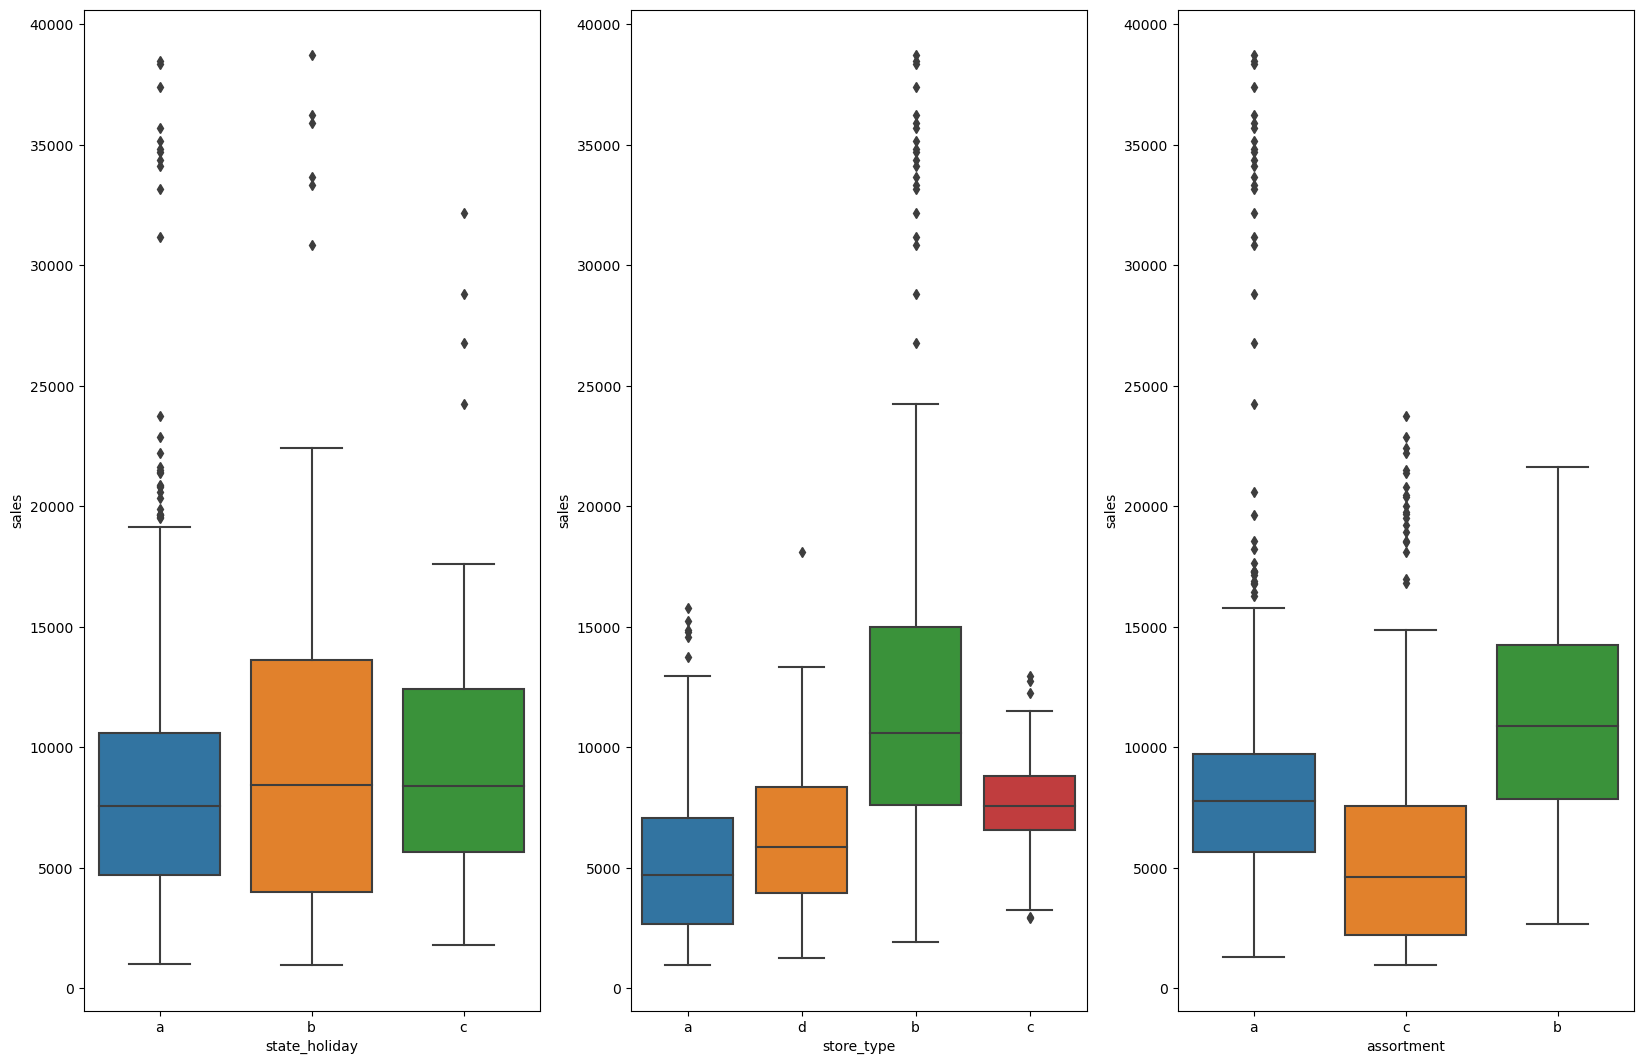

In [26]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0)]

plt.figure(figsize=(20,13))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [27]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

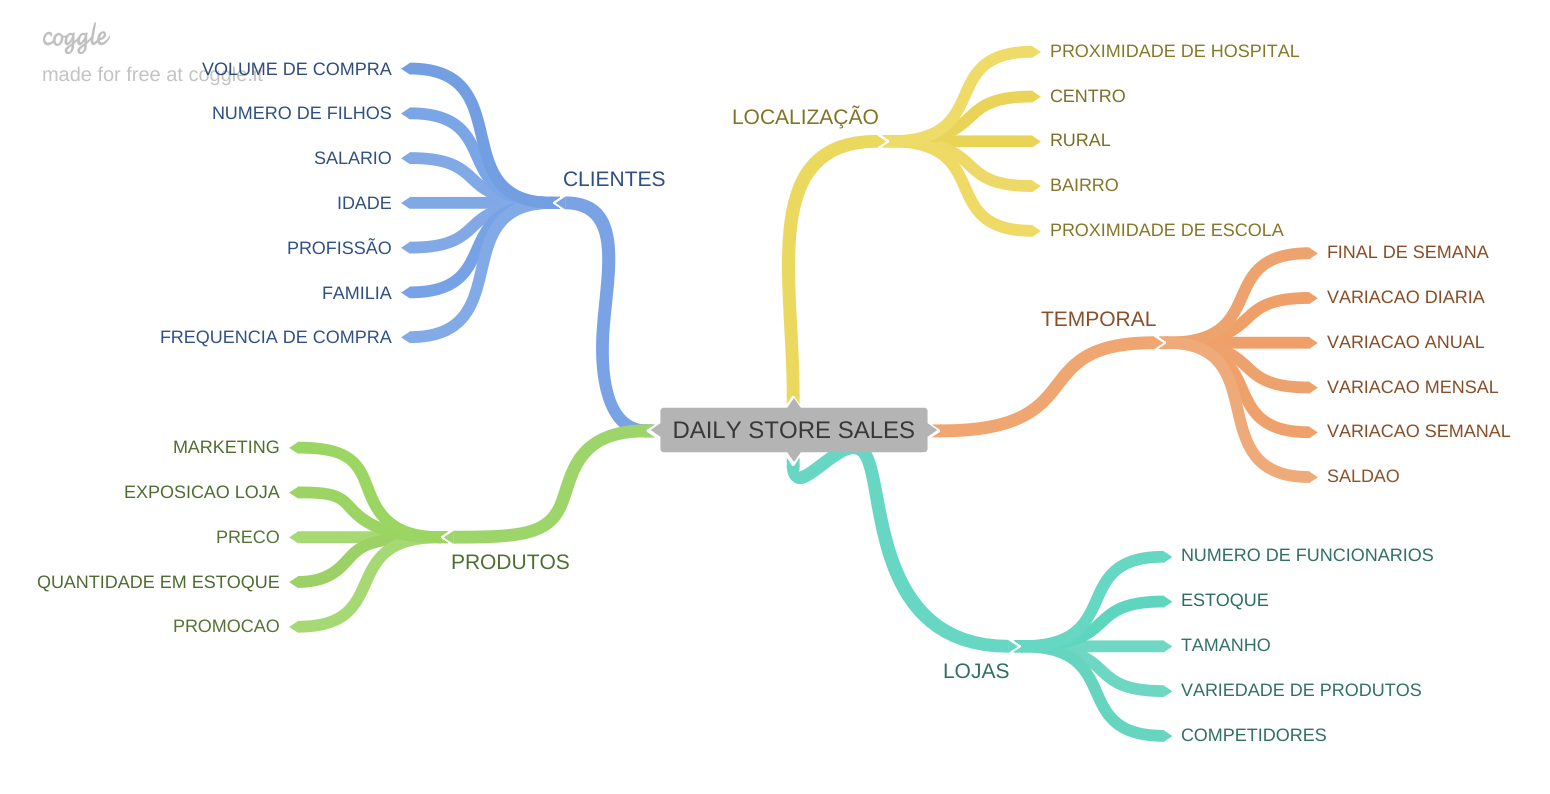

In [28]:
Image('img/MindMapHypotesis.png')

## 2.2 Criacao das Hipoteses

### 2.2.1 Hipoteses Loja

**1.** Loja com maior quadro de funcionarios deveria vender mais

**2.** Lojas com estoque maior vendem mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior variedade de produtos deveriam vender mais

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais


### 2.2.3 Hipoteses Tempo

**1.** Lojas que abrem aos feriados deveriam mais

**2.** Lojas que abrem nos primeiros 6 meses deveriam mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

## 2.3 Lista Final de Hipoteses

-> Interessante usar como criterio de decisao a disponibilidade dos dados que possui no momento

**1.** Lojas com maior variedade de produtos deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriado escolares

## 2.4 Feature Engineering

In [29]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
#df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')

In [30]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0 PASSO 03 - FILTRAGEM DE VARIAVEIS

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [33]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)] 

## 3.2 Selecao das Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANALISE EXPLORATORIA DE DADOS

In [36]:
df4 = df3.copy()

In [37]:
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,a,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,a,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,a,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,c,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,a,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,a,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,b,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,b,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,b,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 4.1 Analise Univariada

### 4.1.1 Resposta da Variavel

<Axes: xlabel='sales', ylabel='Density'>

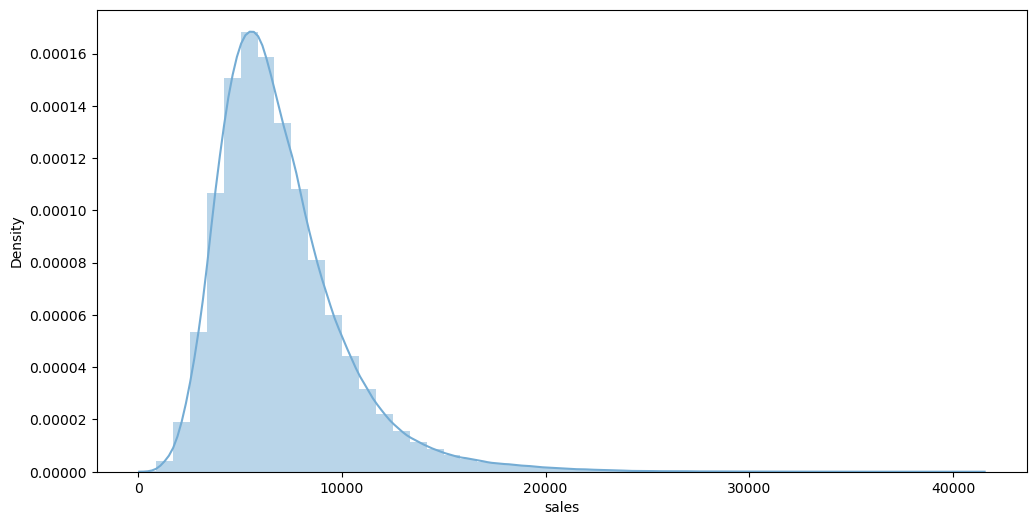

In [38]:
ax = sns.histplot(df4['sales'], stat="density", element="step", bins=50, kde=True, color='#74acd4', lw=0)
ax.figure.set_size_inches(12, 6)
ax

### 4.1.2 Variavel Numerica

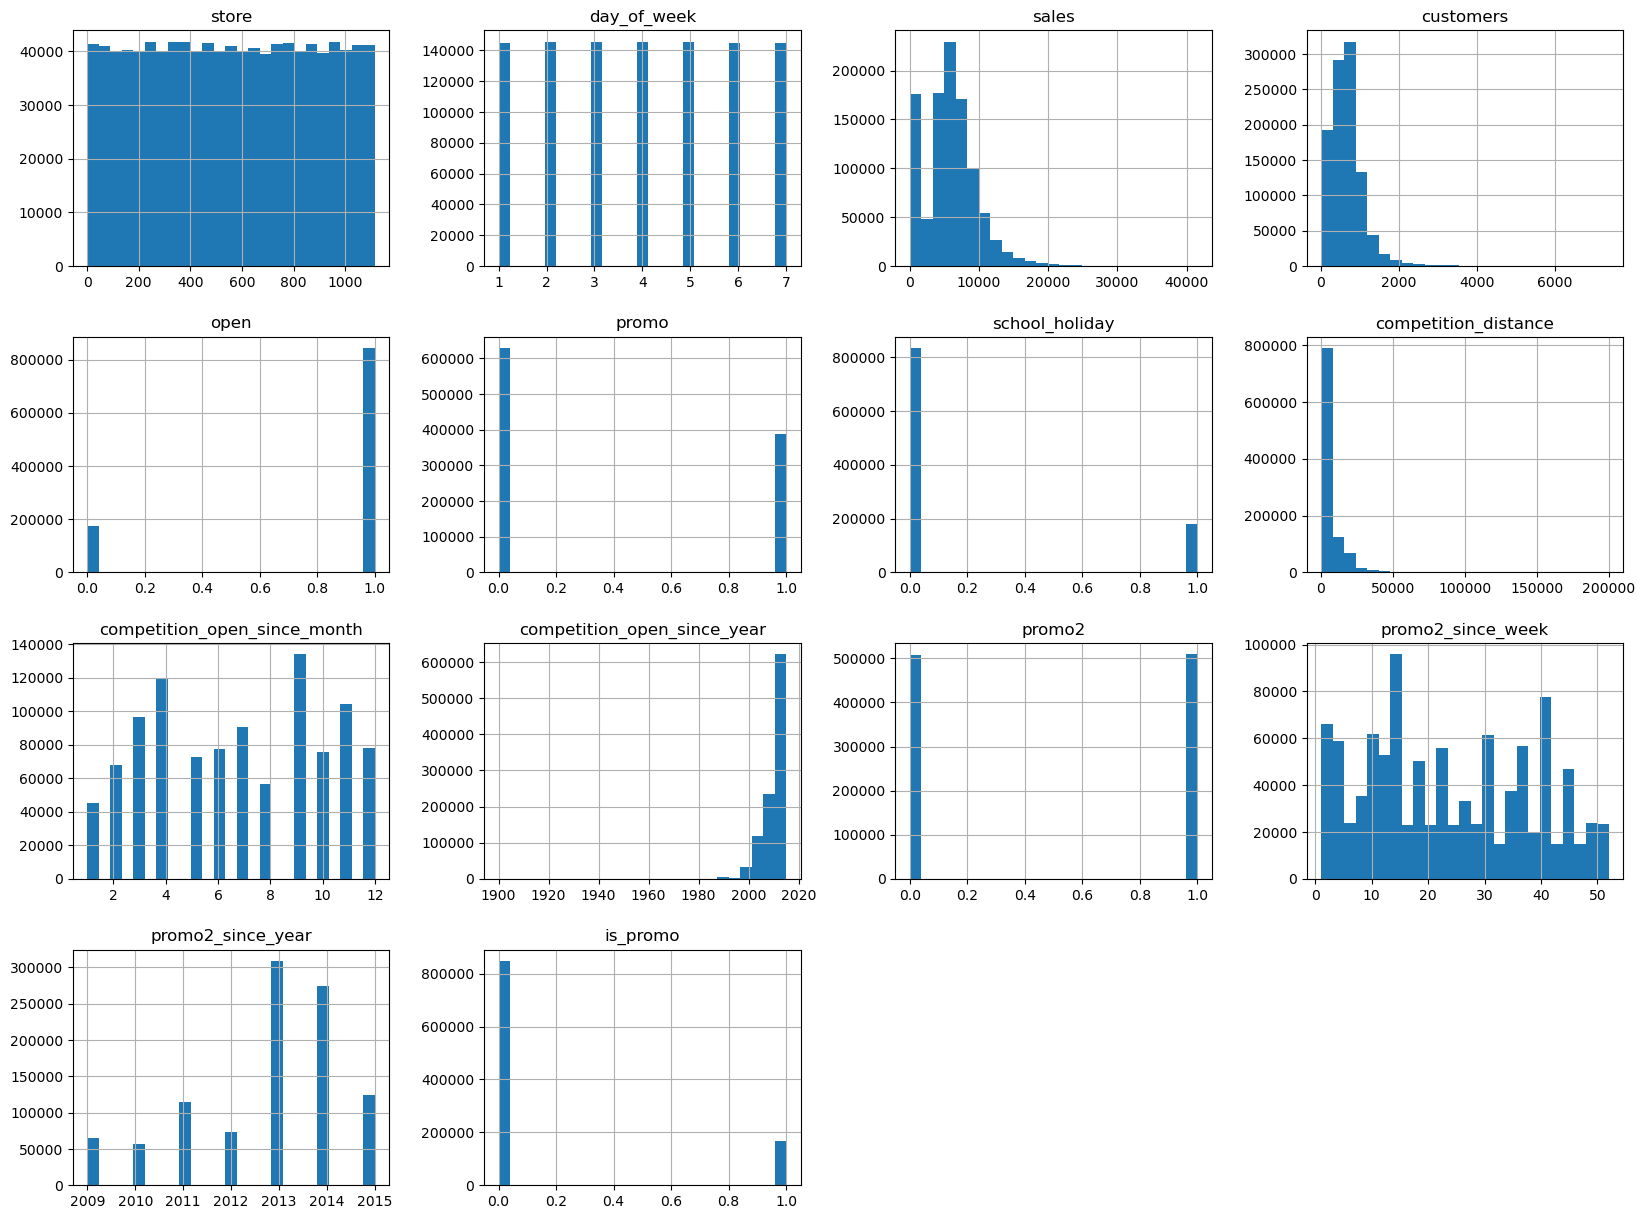

In [39]:
num_attributes.hist(bins=25, figsize=(20,15));

### 4.1.3 Variavel Categorica

<Axes: >

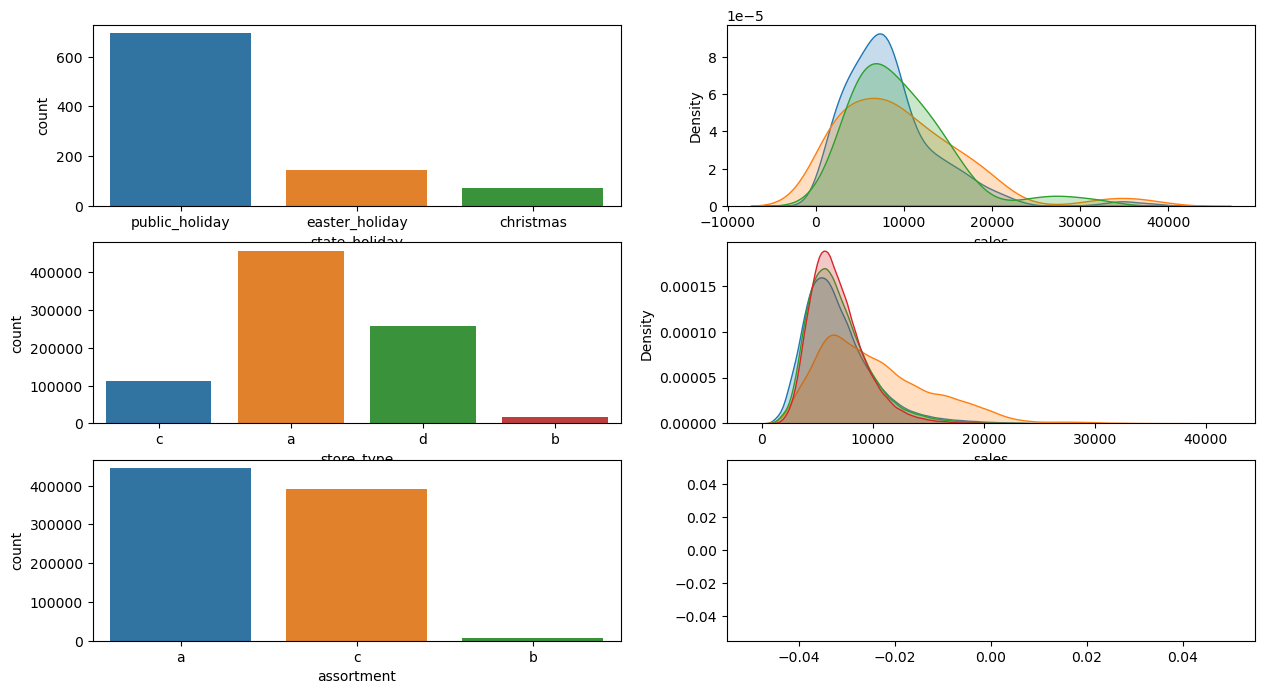

In [40]:
# state_holiday

plt.figure(figsize=(15,8))

plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'], x=(a['state_holiday']))

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x= (df4['store_type']))

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=(df4['assortment'] ))

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2 Analise Bivariada

### **1.** Lojas com maior variedade de produtos deveriam vender mais

**FALSA** Lojas com MAIOR VARIEDADE vendem MENOS

In [41]:
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,a,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,a,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,a,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,c,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,a,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,a,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,b,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,b,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,b,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


<Axes: xlabel='date'>

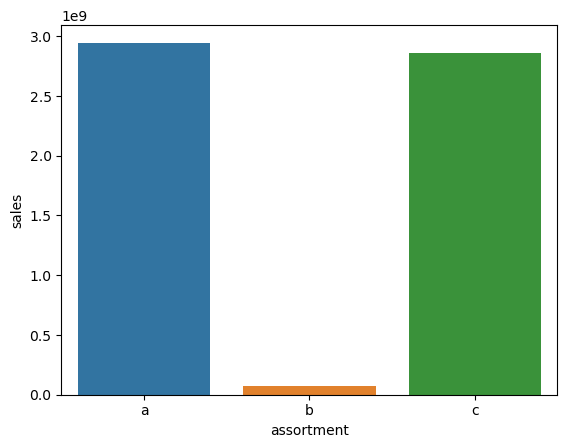

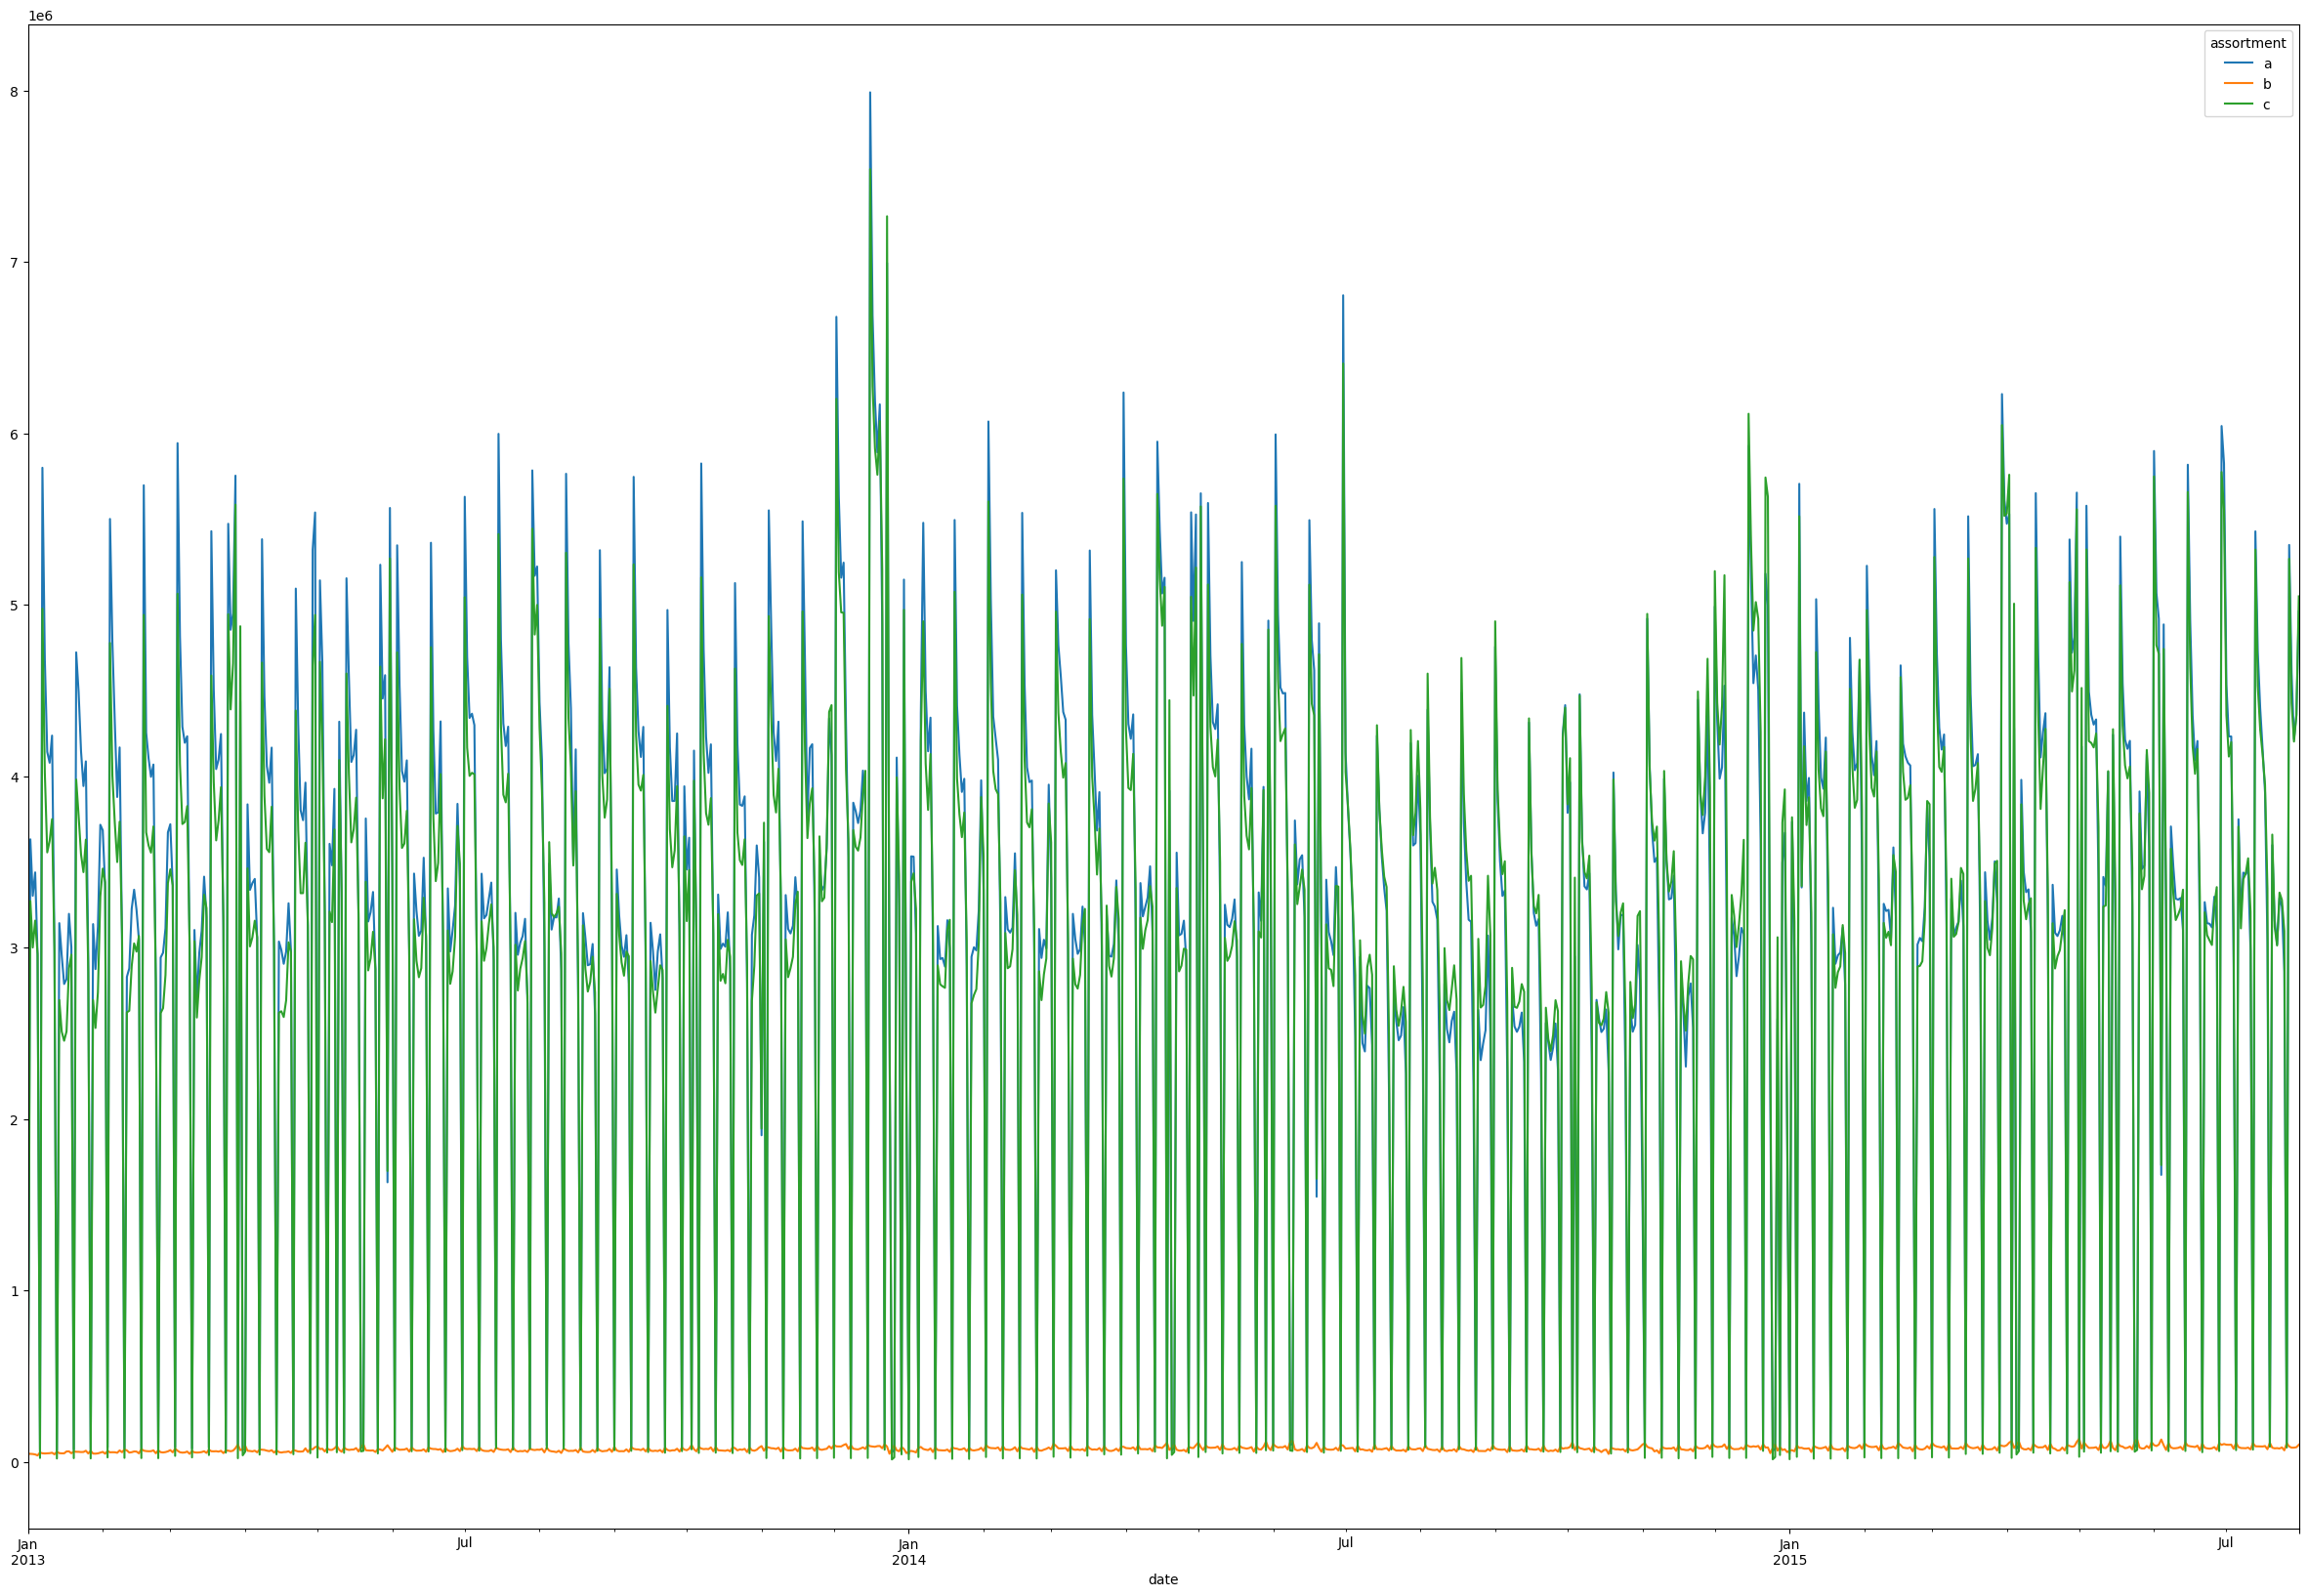

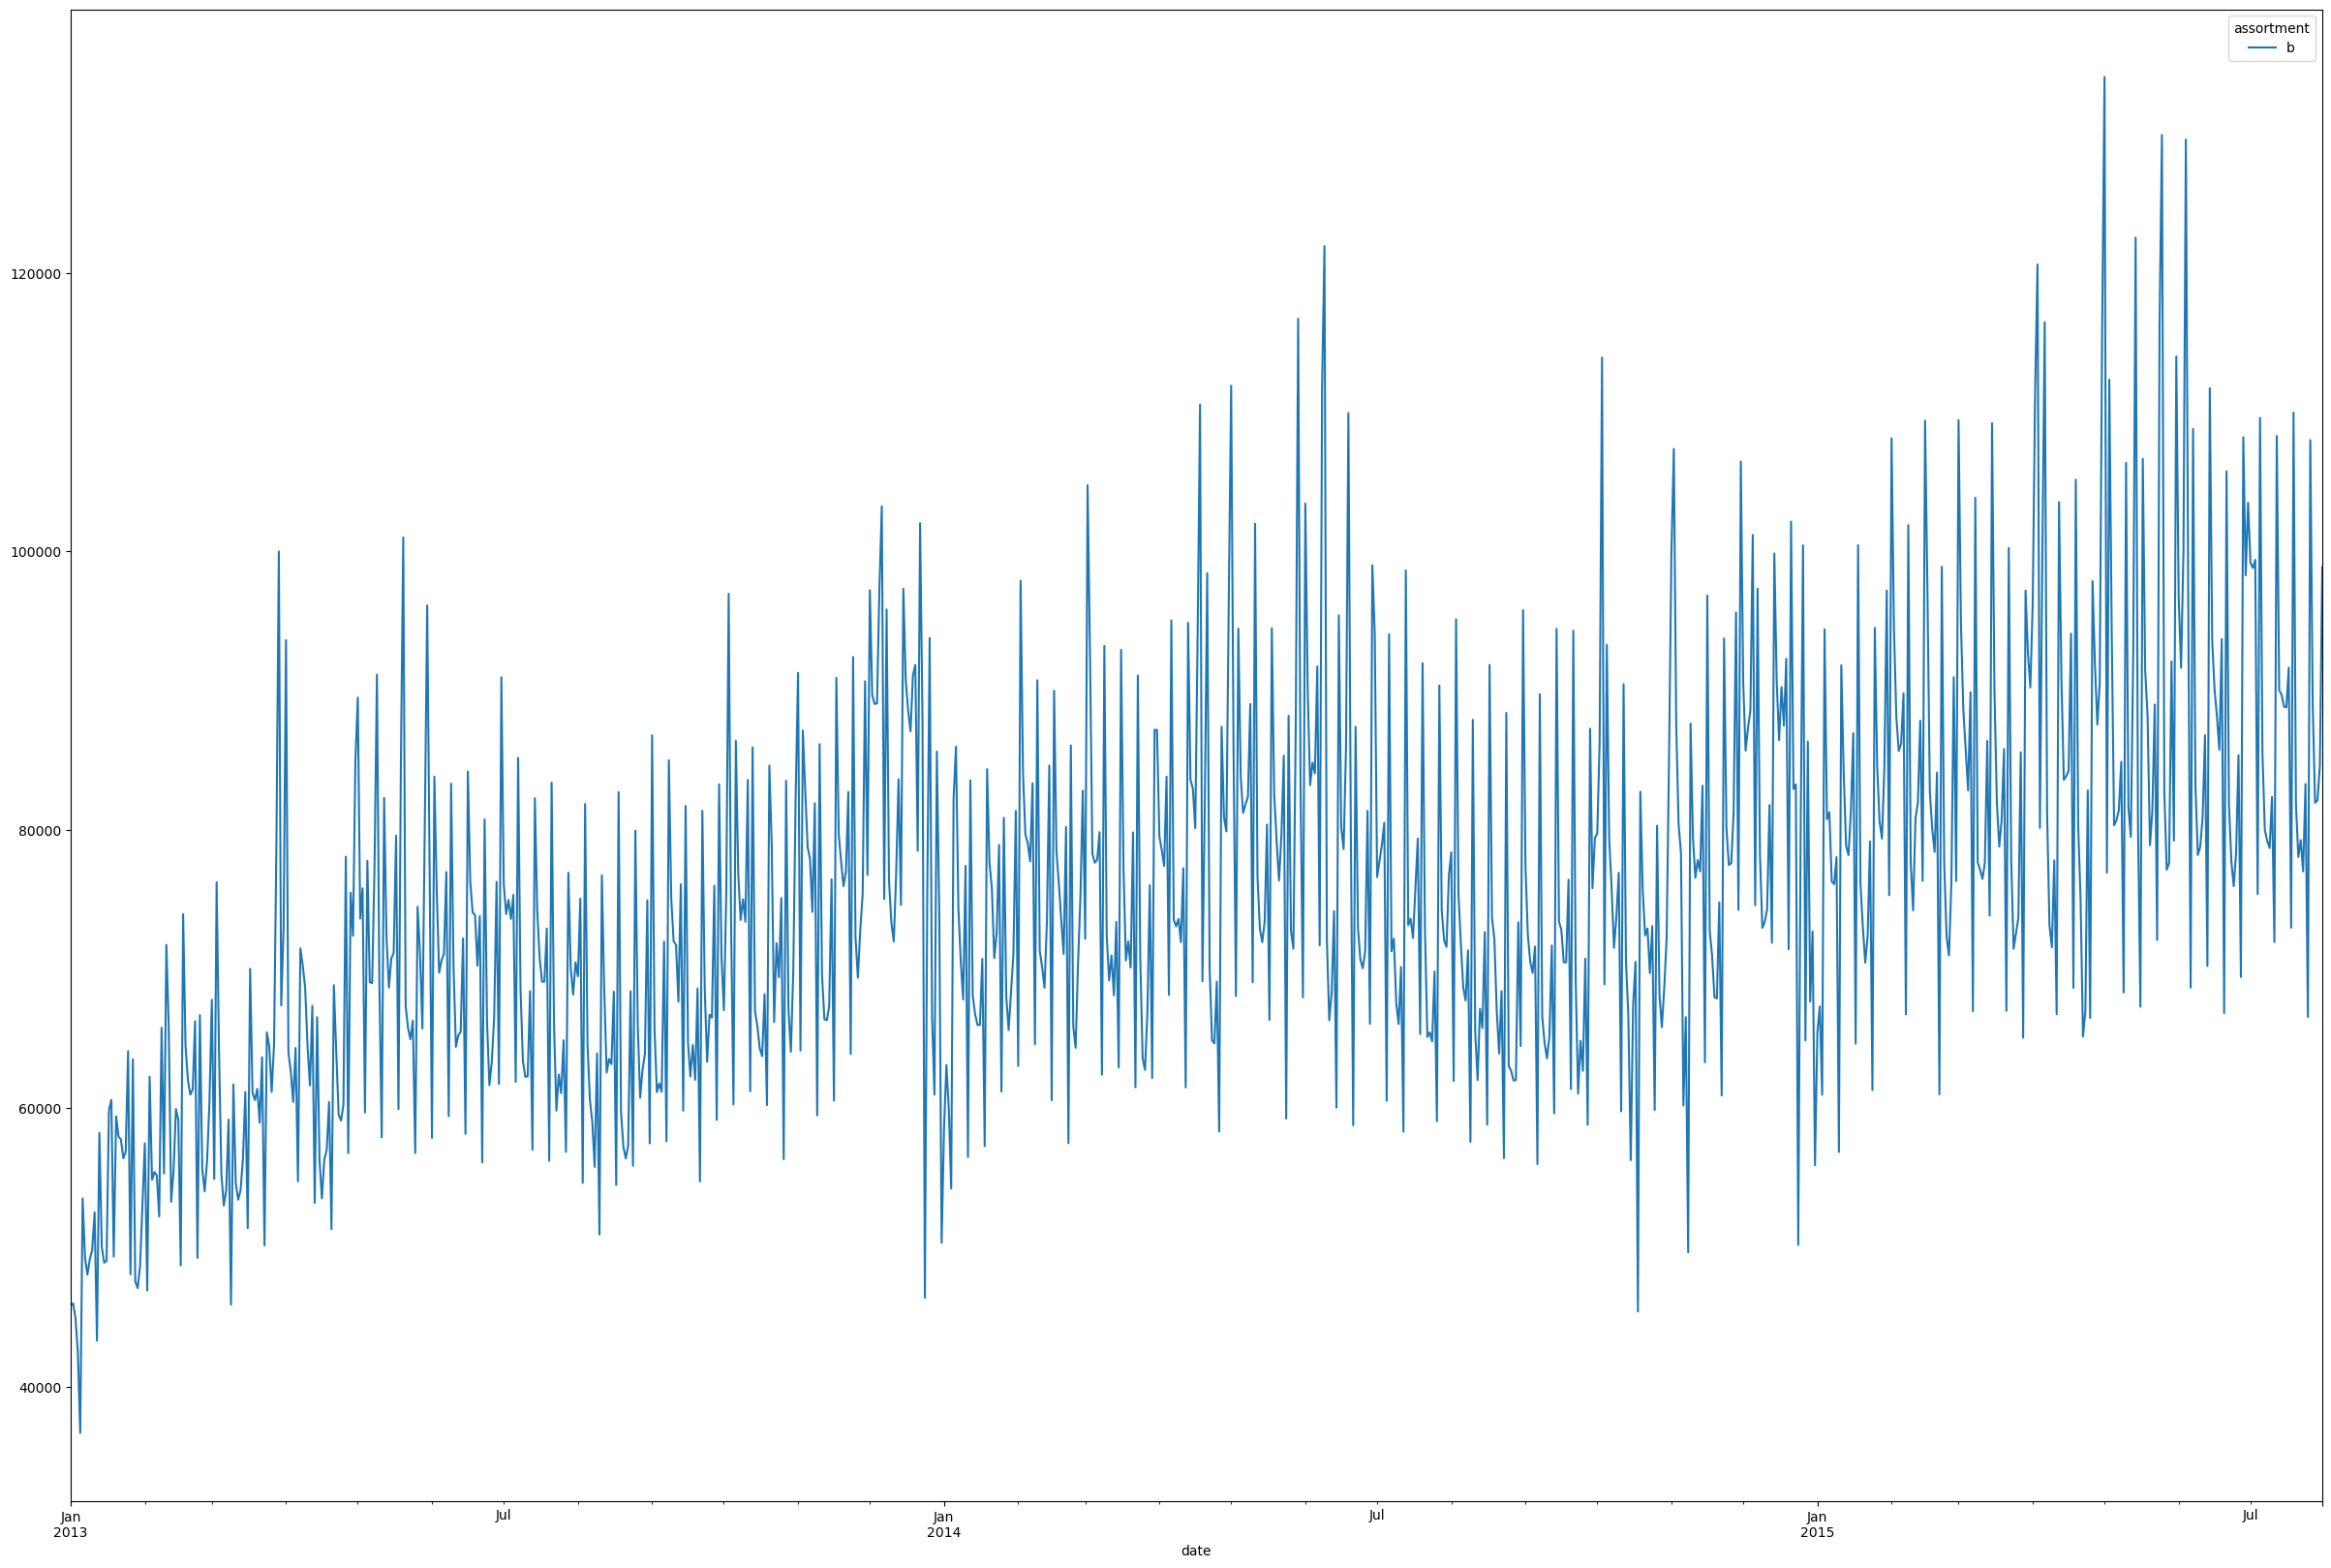

In [42]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['date','assortment', 'sales']].groupby(['date','assortment']).sum().reset_index()
aux2.pivot(index= 'date', columns= 'assortment', values='sales').plot(figsize=(30,20))

aux3 = aux2[aux2['assortment'] == 'b']
aux3.pivot(index='date', columns='assortment', values='sales').plot(figsize=(30,20))

### **2.** Lojas com competidores mais próximos deveriam vender menos

**FALSA** Lojas com competidores MAIS PRÓXIMOS vendem MAIS

C:\Users\thais\AppData\Local\Temp\ipykernel_15928\2060729834.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  h = sns.heatmap(aux4.corr(method='pearson'), annot=True);


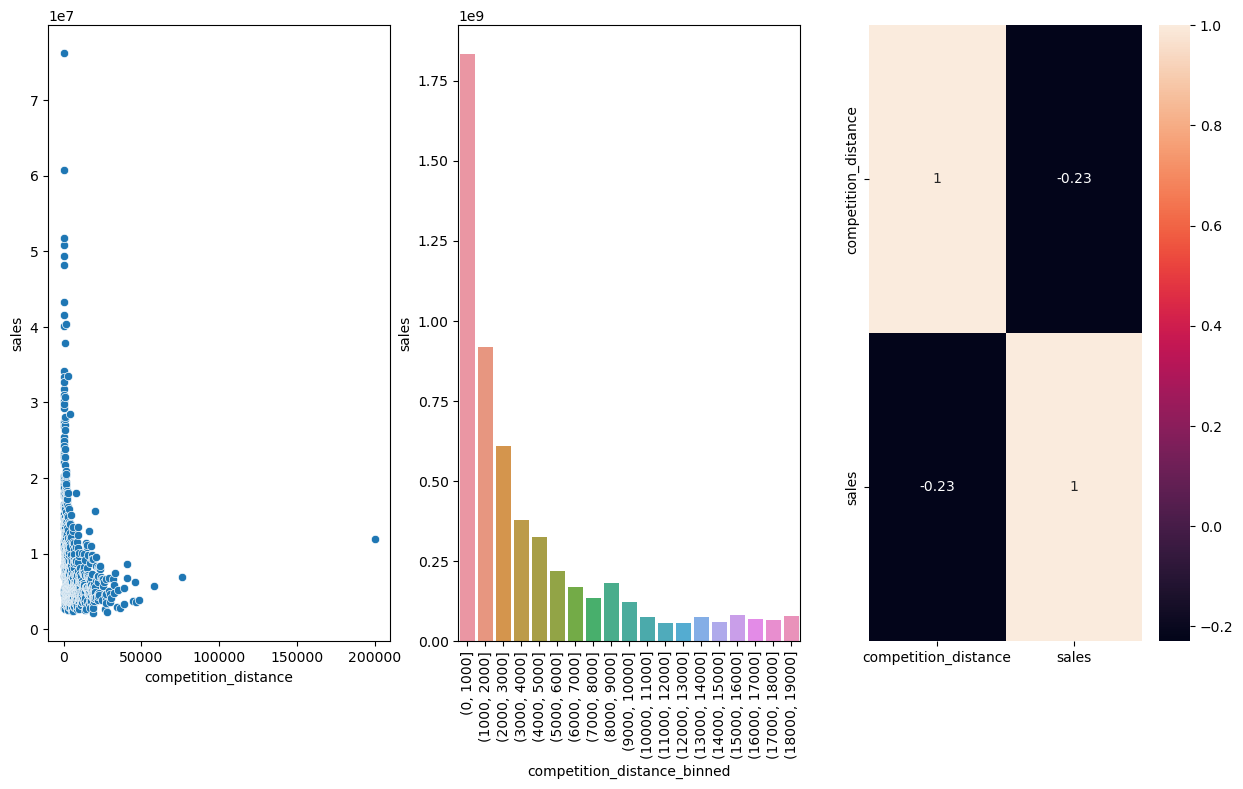

In [43]:
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux4);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5 = aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux5);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
h = sns.heatmap(aux4.corr(method='pearson'), annot=True);

In [44]:
aux4.sample(4)

,competition_distance,sales,competition_distance_binned
35,370.0,10783867,"(0.0, 1000.0]"
641,34050.0,2914087,NaN
431,7890.0,5288733,"(7000.0, 8000.0]"
415,7180.0,5643678,"(7000.0, 8000.0]"


###  **3.** Lojas com competidores a mais tempo deveriam vender mais

**FALSE** Lojas com competidores há mais tempo vendem MENOS. 

In [45]:
plt.rcParams["figure.figsize"] = (20, 15)

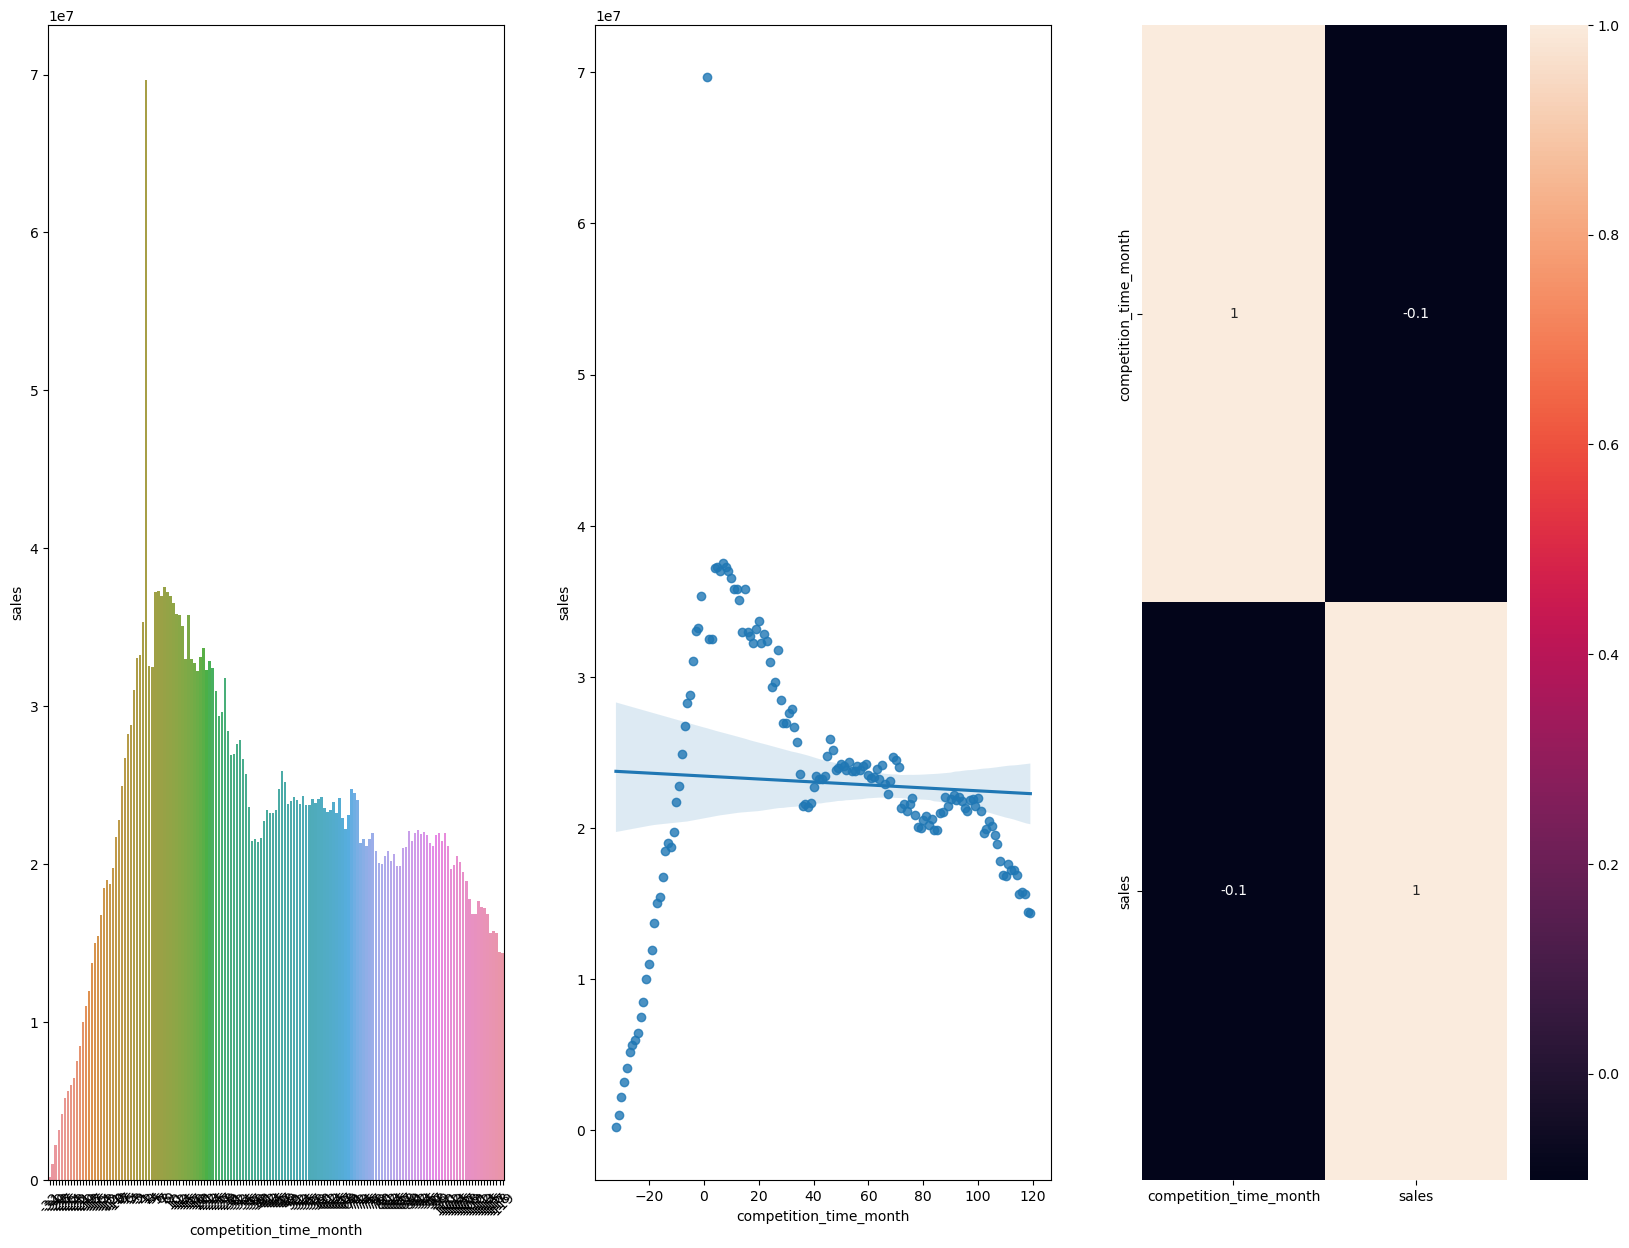

In [46]:
plt.subplot(1,3,1)
aux6 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux7 = aux6[(aux6['competition_time_month'] < 120) & (aux6['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux7);
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux7);

plt.subplot(1,3,3)
x = sns.heatmap(aux6.corr(method='pearson'), annot=True);

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais

**FALSA** As promoções vendem mais por um determinado tempo

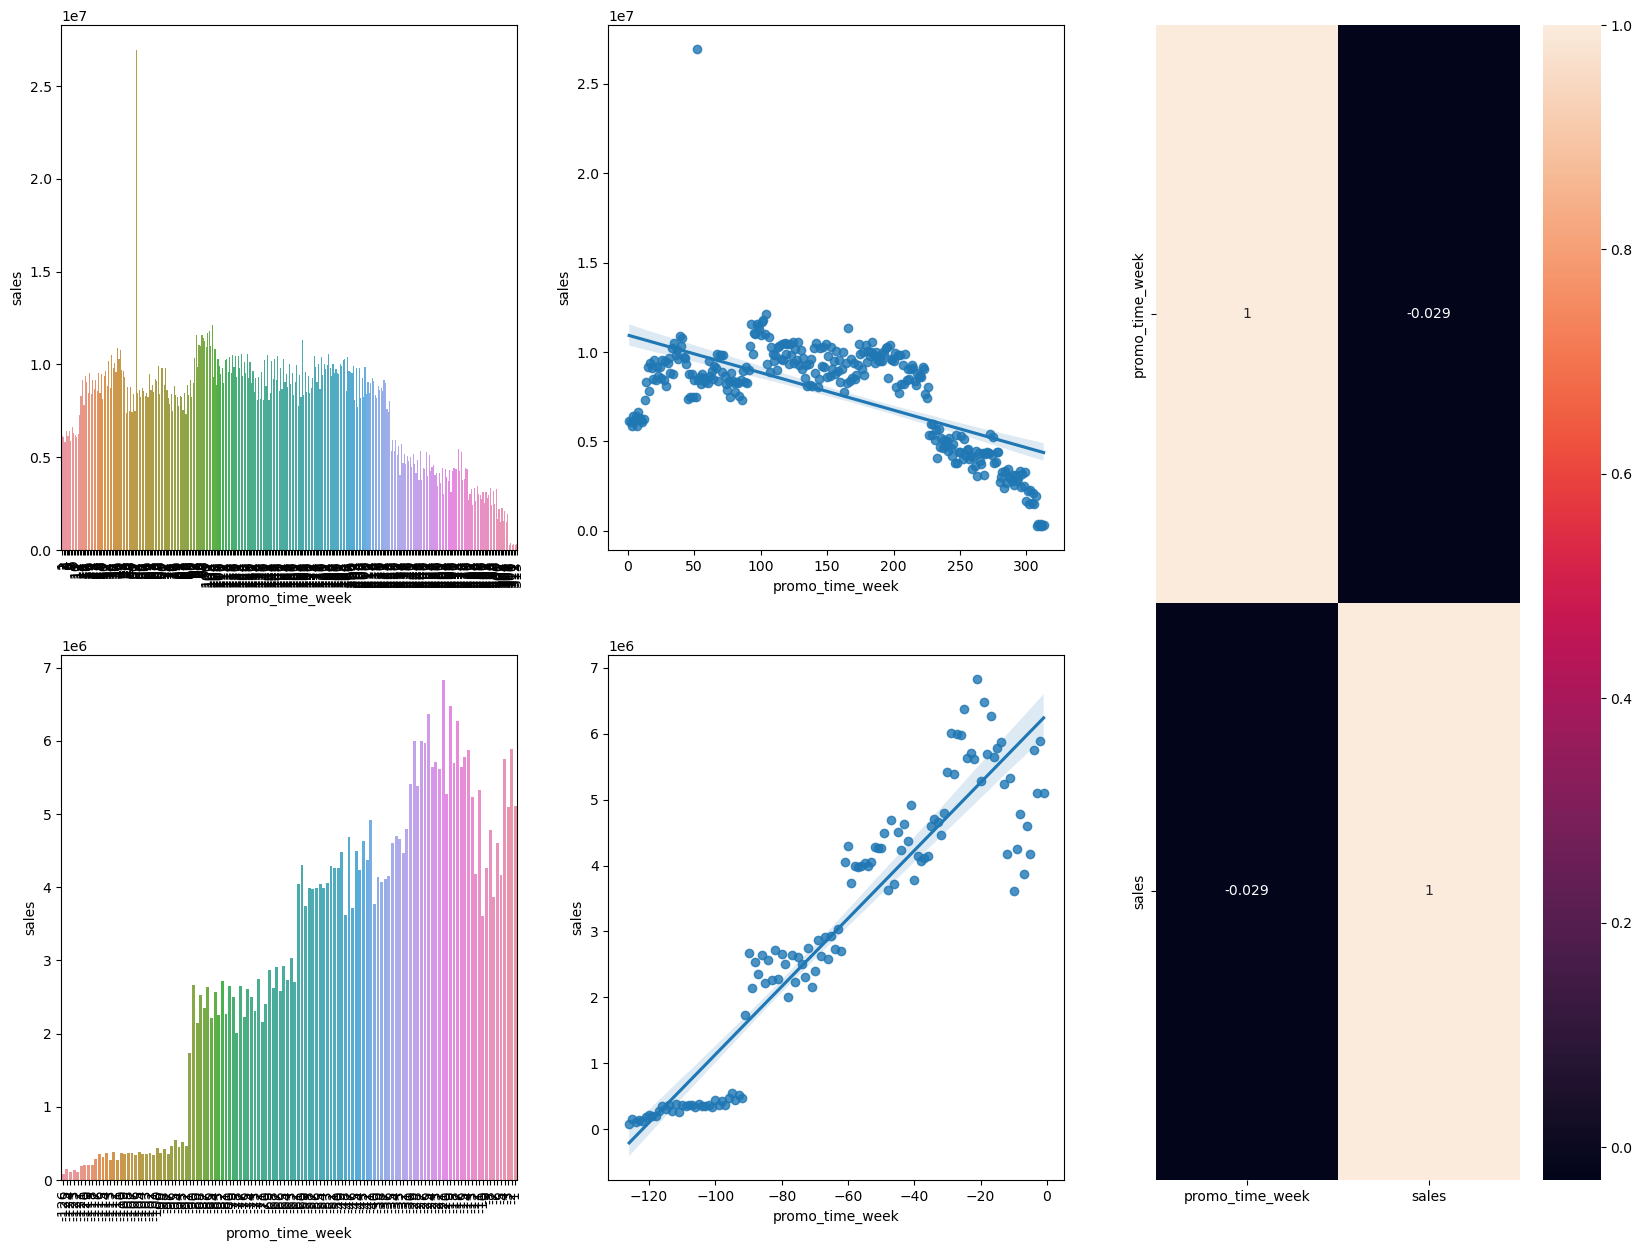

In [47]:
aux8 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux9 = aux8[aux8['promo_time_week'] > 0] #promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux9);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux9)

plt.subplot(grid[1,0])
aux10 = aux8[aux8['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux10 );
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux10)

plt.subplot(grid[:,2])
sns.heatmap(aux8.corr(method='pearson'), annot=True);

### <s> 5. Lojas com mais dias de promoção deveriam vender mais </s>

### 6.Lojas com mais promoções consecutivas deveriam vender mais

**FALSA** Lojas com promoções consecutivas vendem menos

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


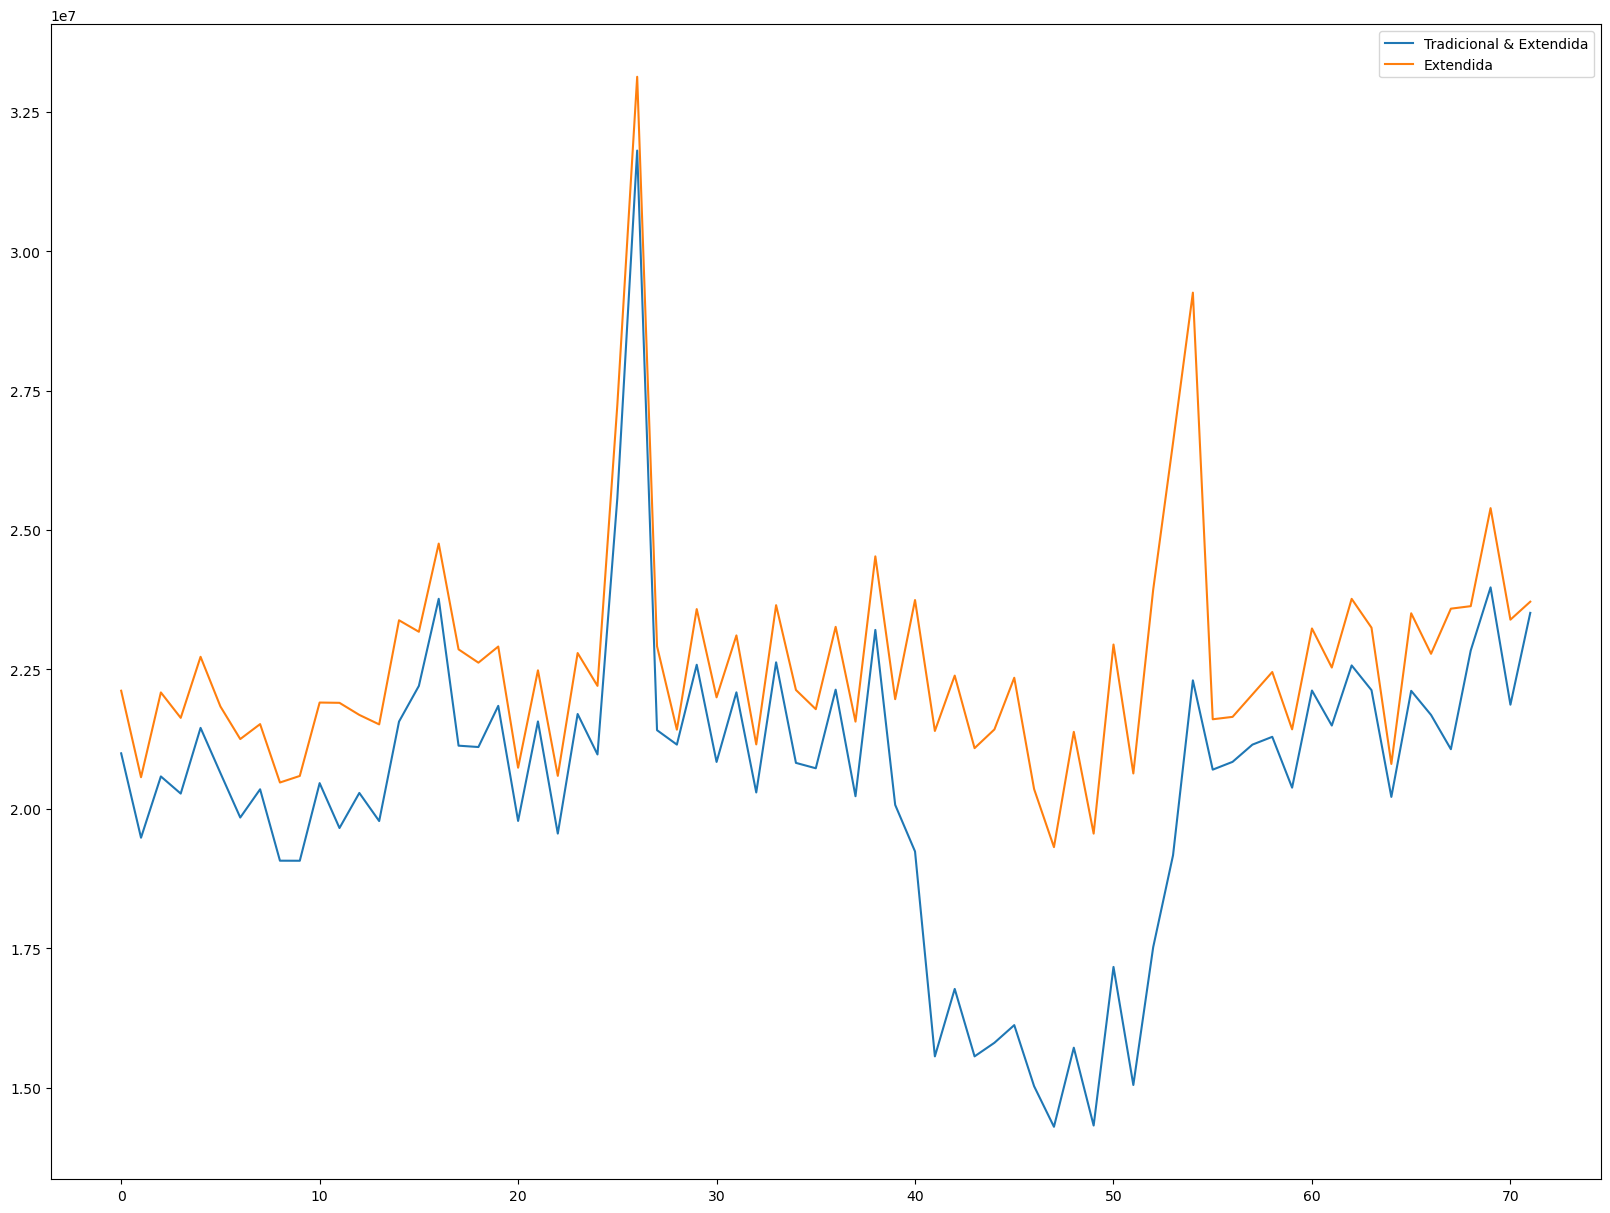

In [49]:
aux11 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux11.plot()

aux12 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux12.plot(ax=ax)

ax.legend(labels =['Tradicional & Extendida', 'Extendida']);

### 7. Lojas abertas durante o feriado de Natal deveriam vender mais

**FALSA** Lojas abertas durante o feriado do Natal vendem menos


<Axes: xlabel='year', ylabel='sales'>

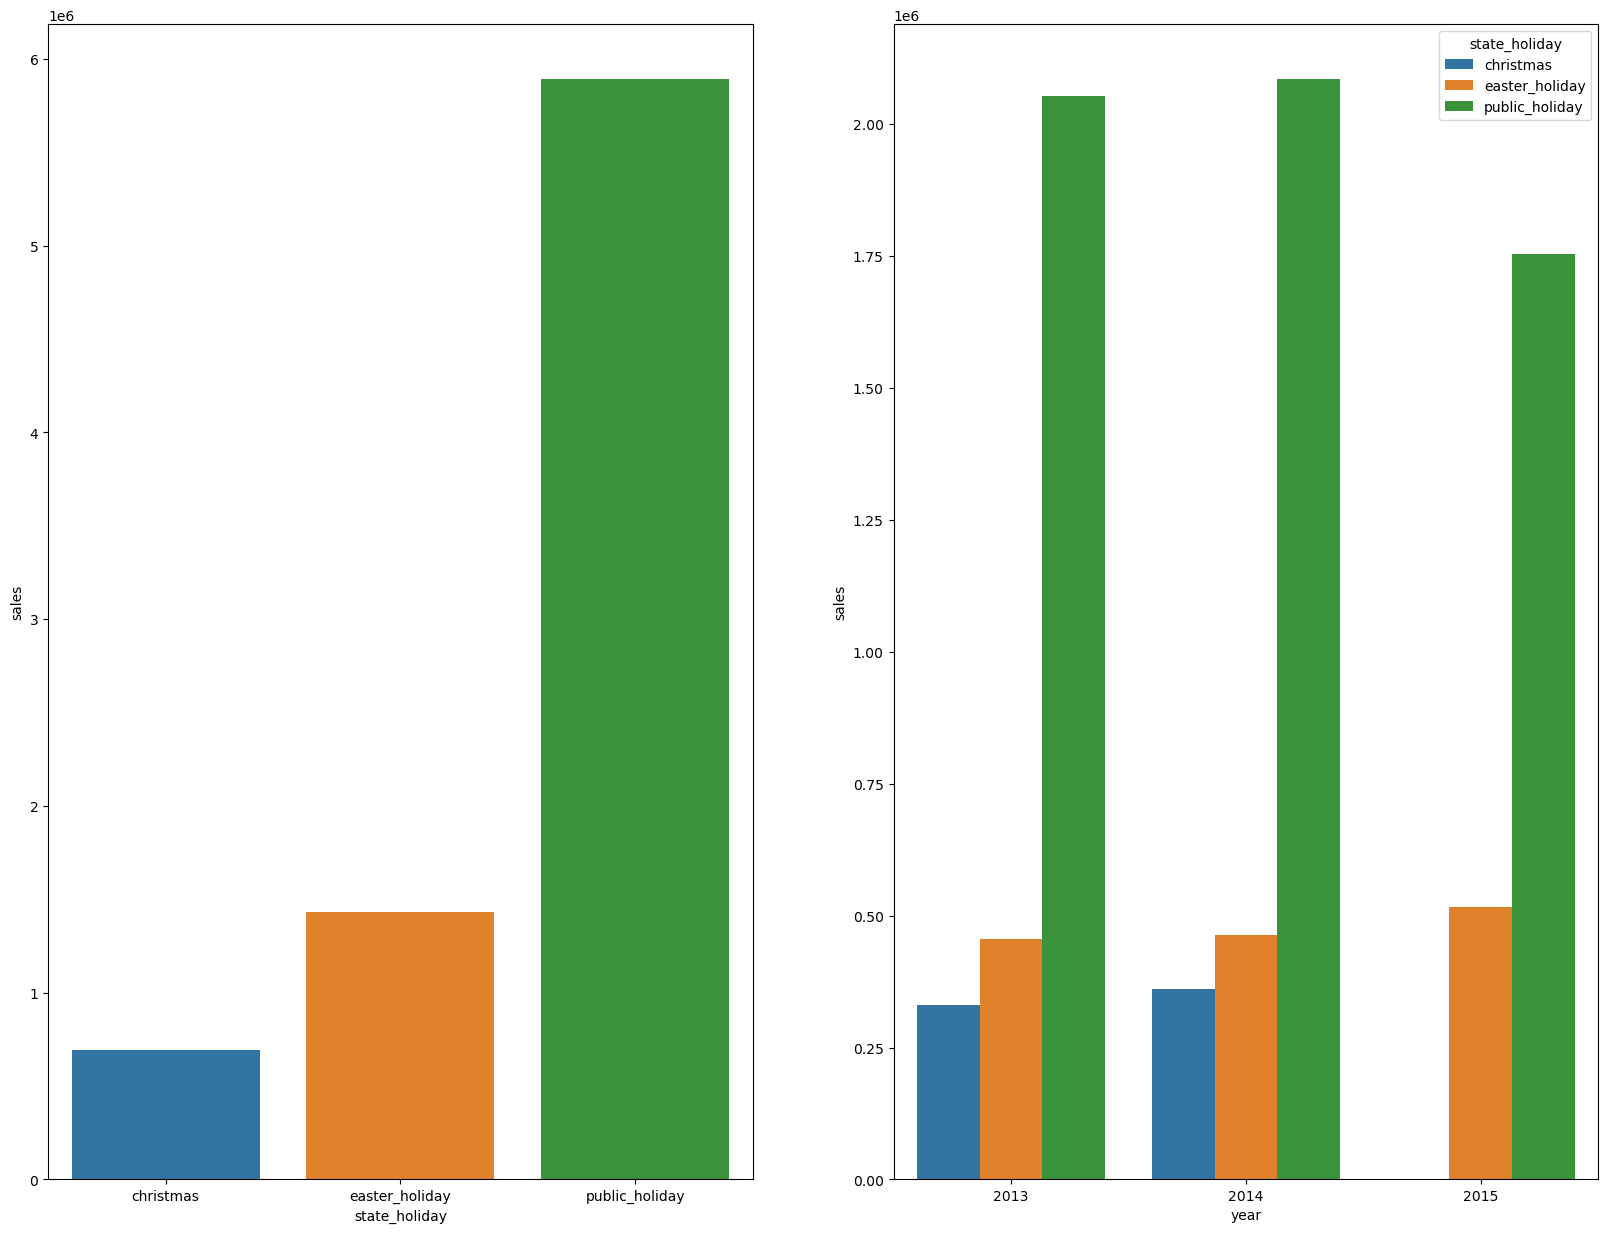

In [50]:
aux13 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux14 = aux13[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux14)

plt.subplot(1,2,2)
aux15 = aux13[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux15)

### 8 Lojas deveriam vender mais ao longo dos anos
-> os dados não possuem o ano de 2015 completo

**FALSA** Lojas vendem menos ao longo do tempo

<Axes: >

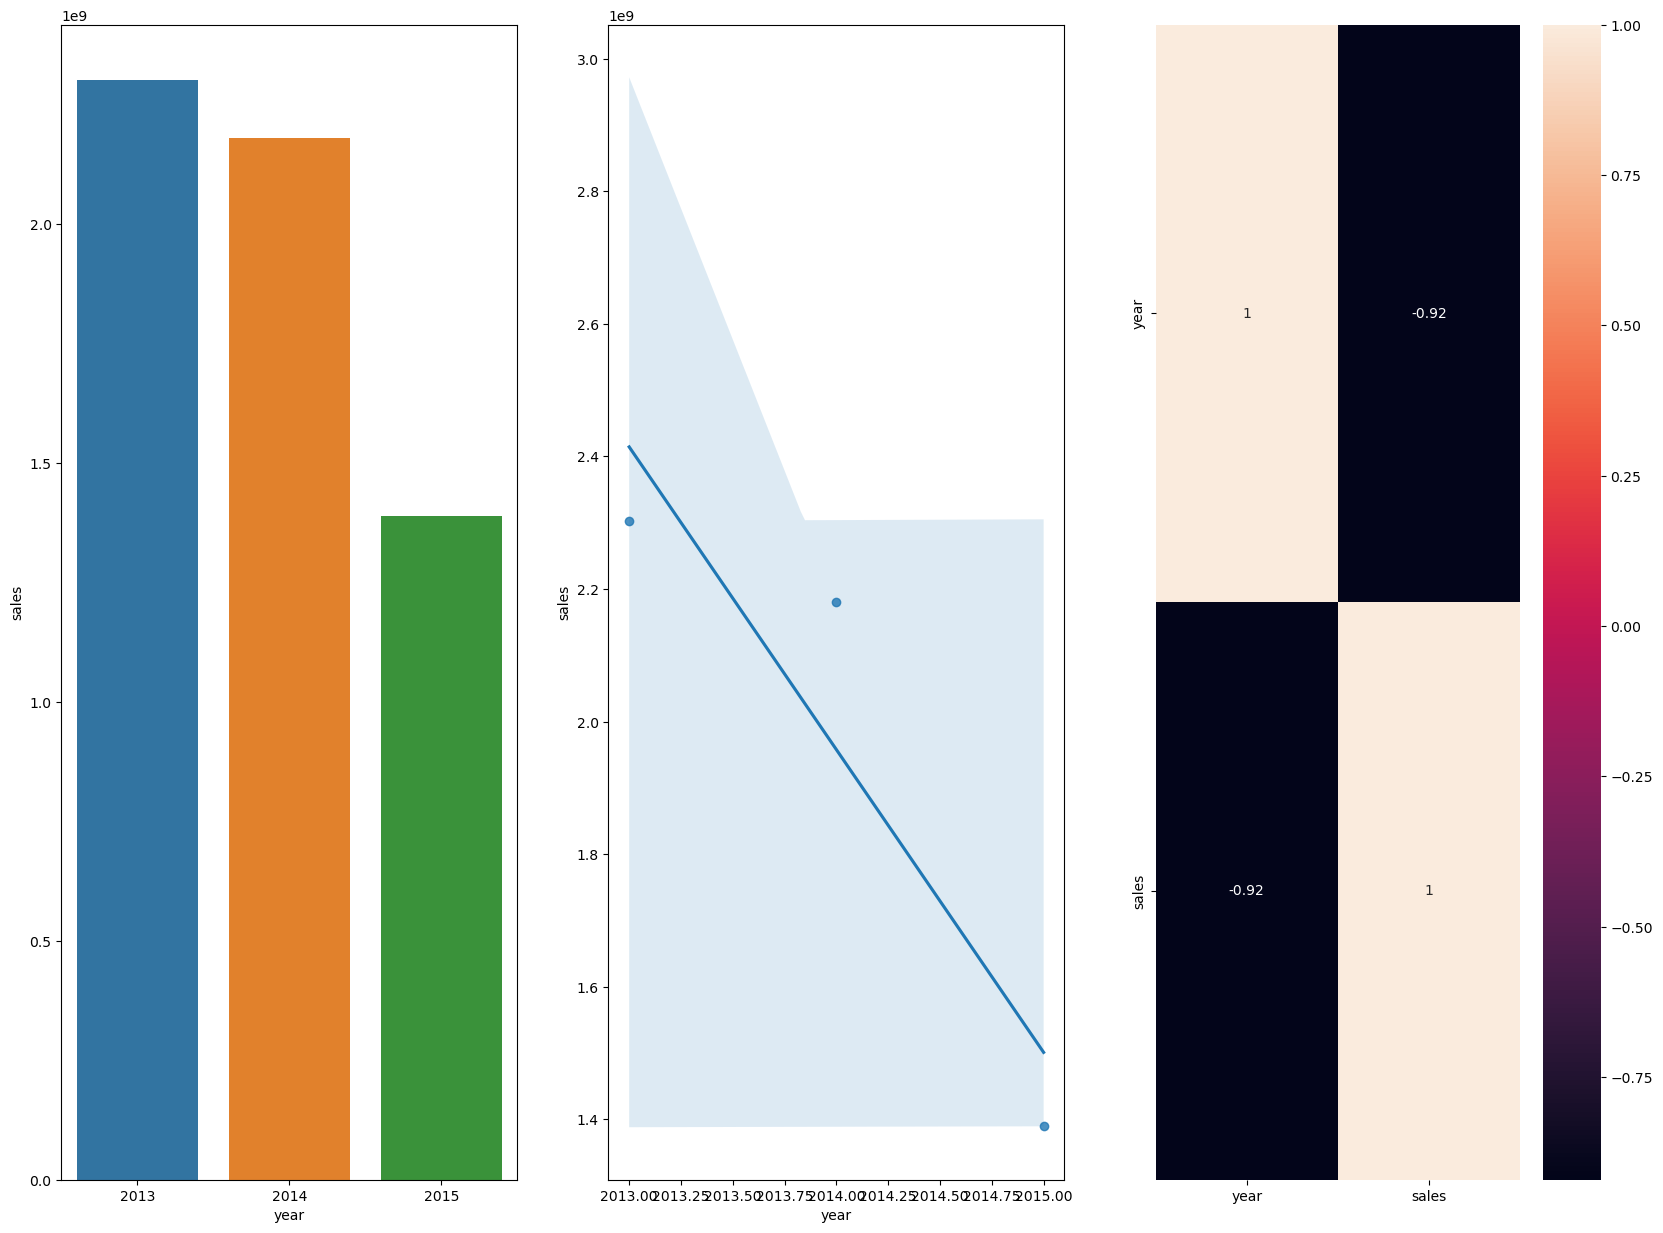

In [51]:
aux16 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux16);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux16);

plt.subplot(1,3,3)
sns.heatmap(aux16.corr(method = 'pearson'), annot=True)


### 9. Lojas deveriam vender mais no segundo semestre do ano

**FALSA** Lojas menos no segundo semestre do ano

<Axes: >

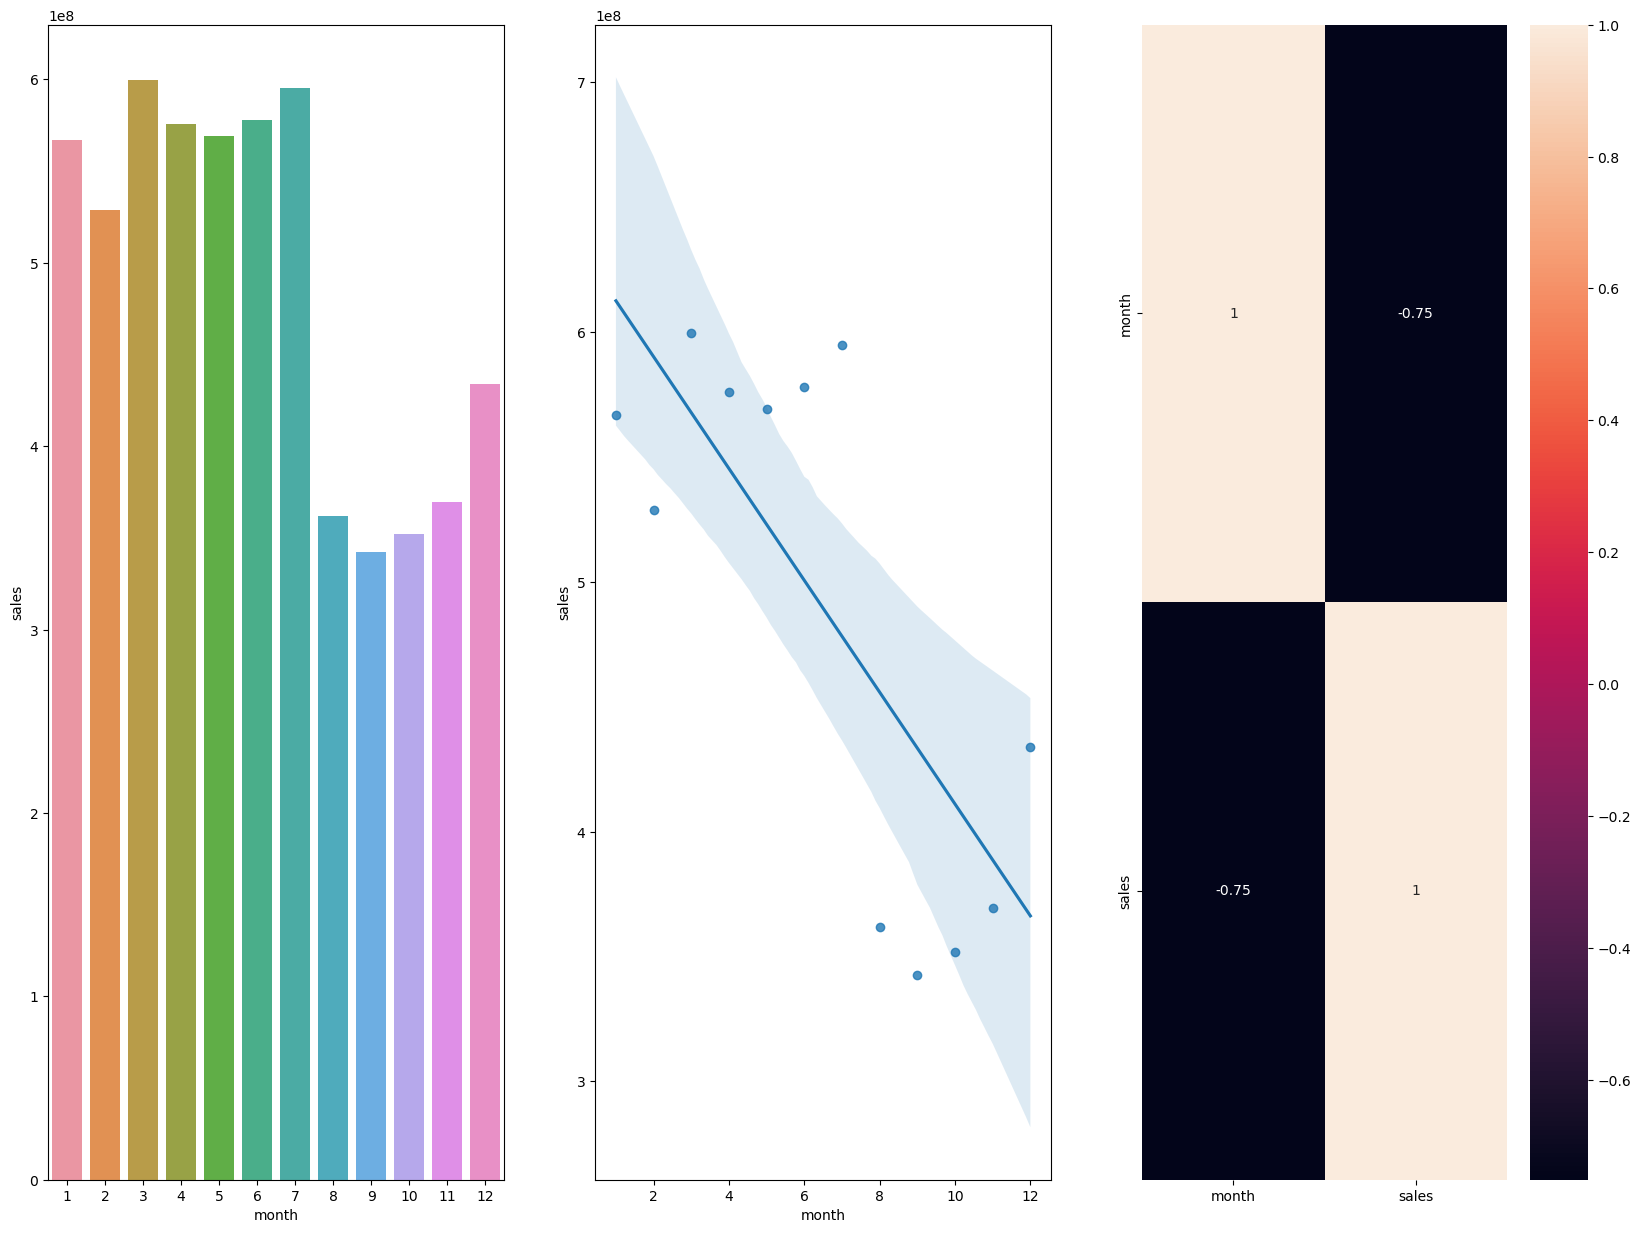

In [52]:
aux16 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux16);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux16);

plt.subplot(1,3,3)
sns.heatmap(aux16.corr(method = 'pearson'), annot=True)


### 10. Lojas deveriam vender mais depois do dia 10 de cada mês

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês 

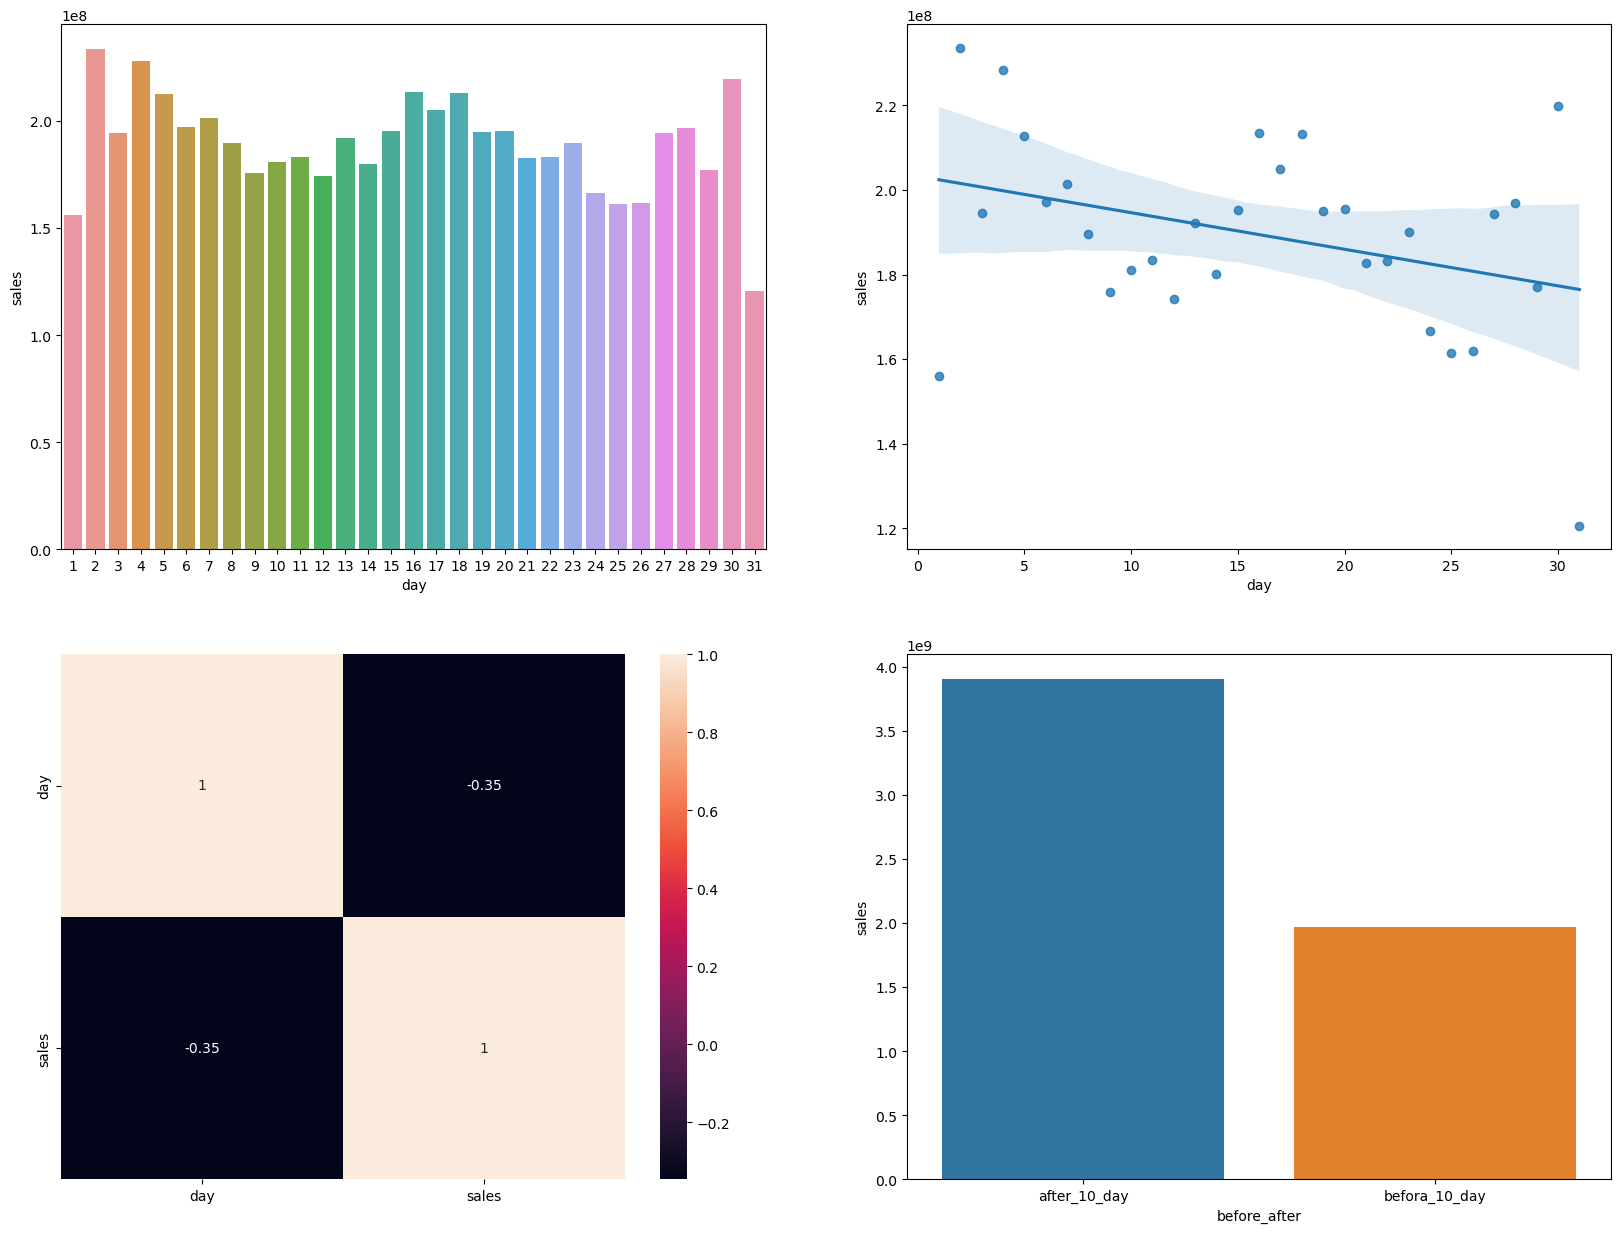

In [53]:
aux16 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux16);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux16);

plt.subplot(2,2,3)
sns.heatmap(aux16.corr(method = 'pearson'), annot=True)

plt.subplot(2,2,4)
aux16['before_after'] = aux16['day'].apply(lambda x: 'befora_10_day' if x <= 10 else 'after_10_day')
aux17 = aux16[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux17);


### 11. Lojas deveriam vender menos aos finais de semana

**VERDADEIRA** Lojas vendem menos no final de semana

<Axes: >

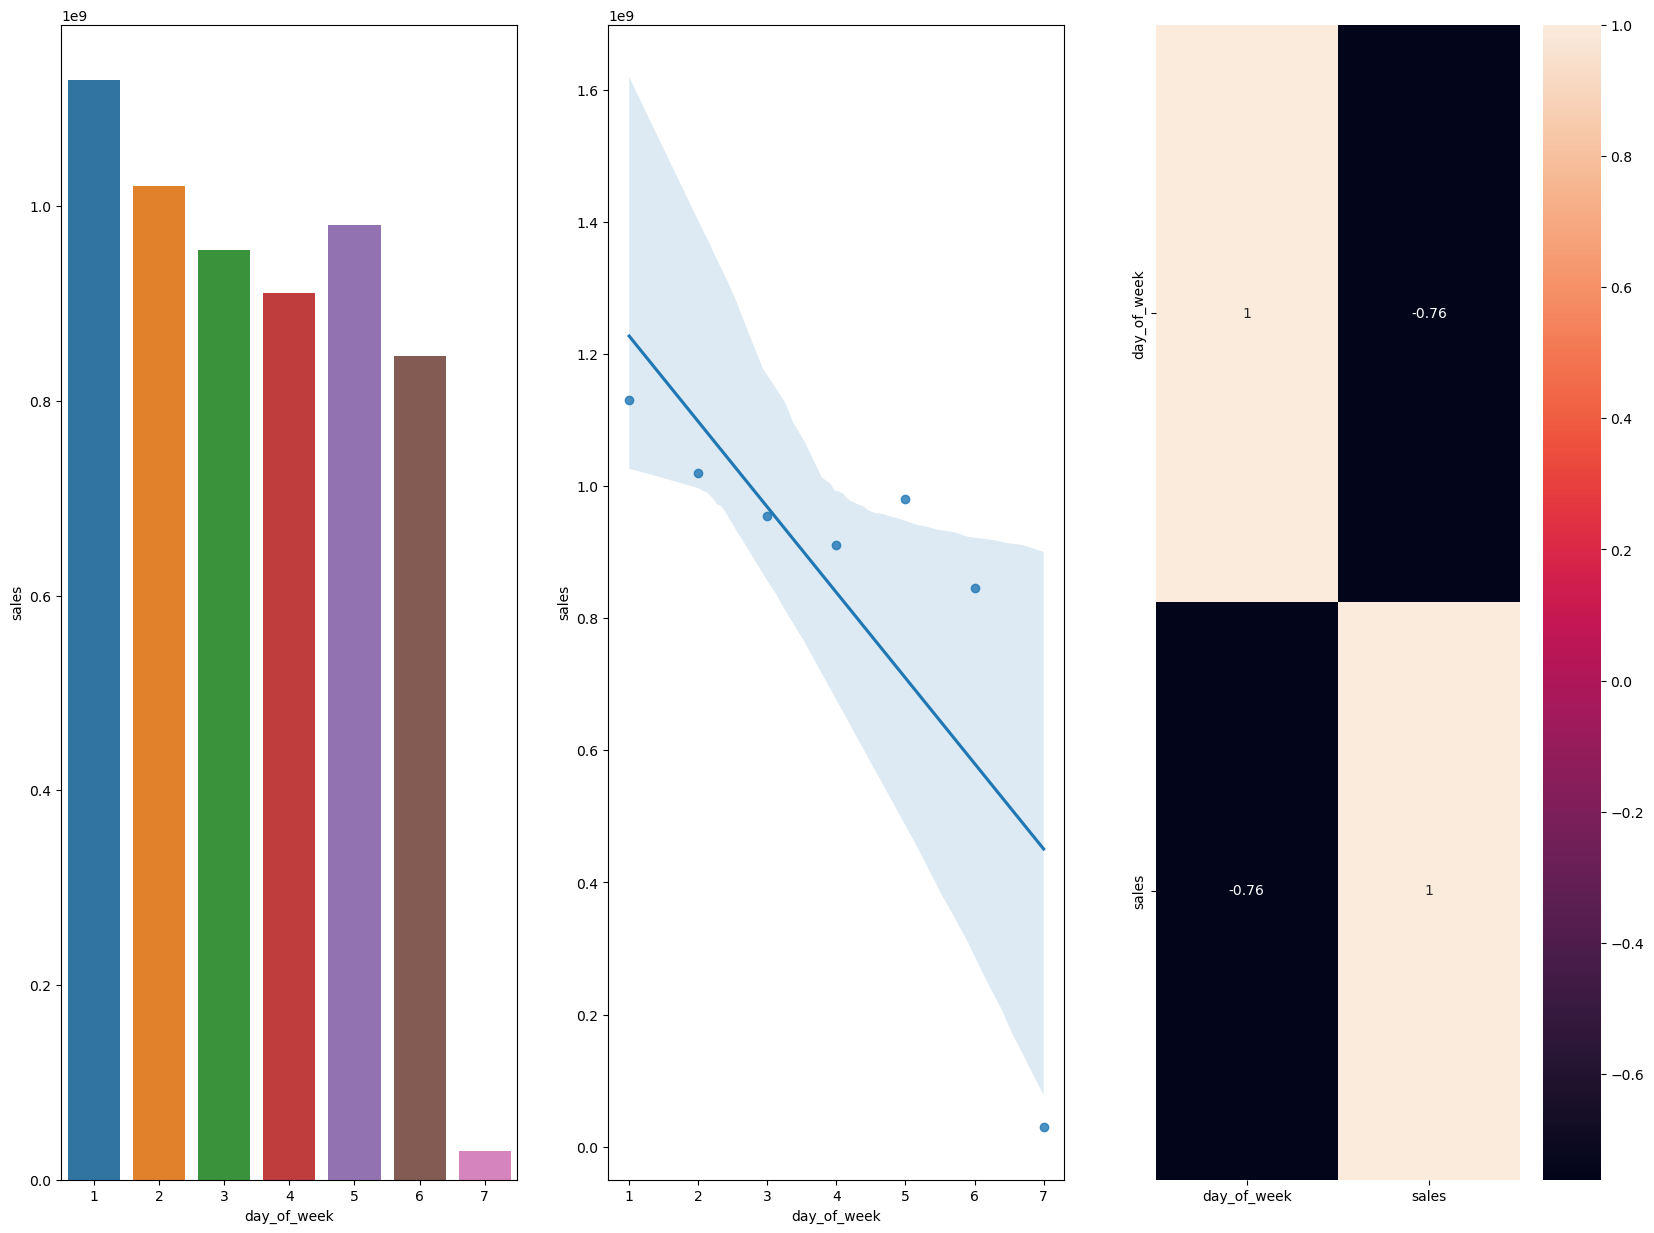

In [54]:
aux16 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux16);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux16);

plt.subplot(1,3,3)
sns.heatmap(aux16.corr(method = 'pearson'), annot=True)

### 12. Lojas deveriam vender menos durante os feriado escolares

**VERDADEIRA** Vendem menos durante os feriados escolares exceto os meses de Julho e Agosto

<Axes: xlabel='month', ylabel='sales'>

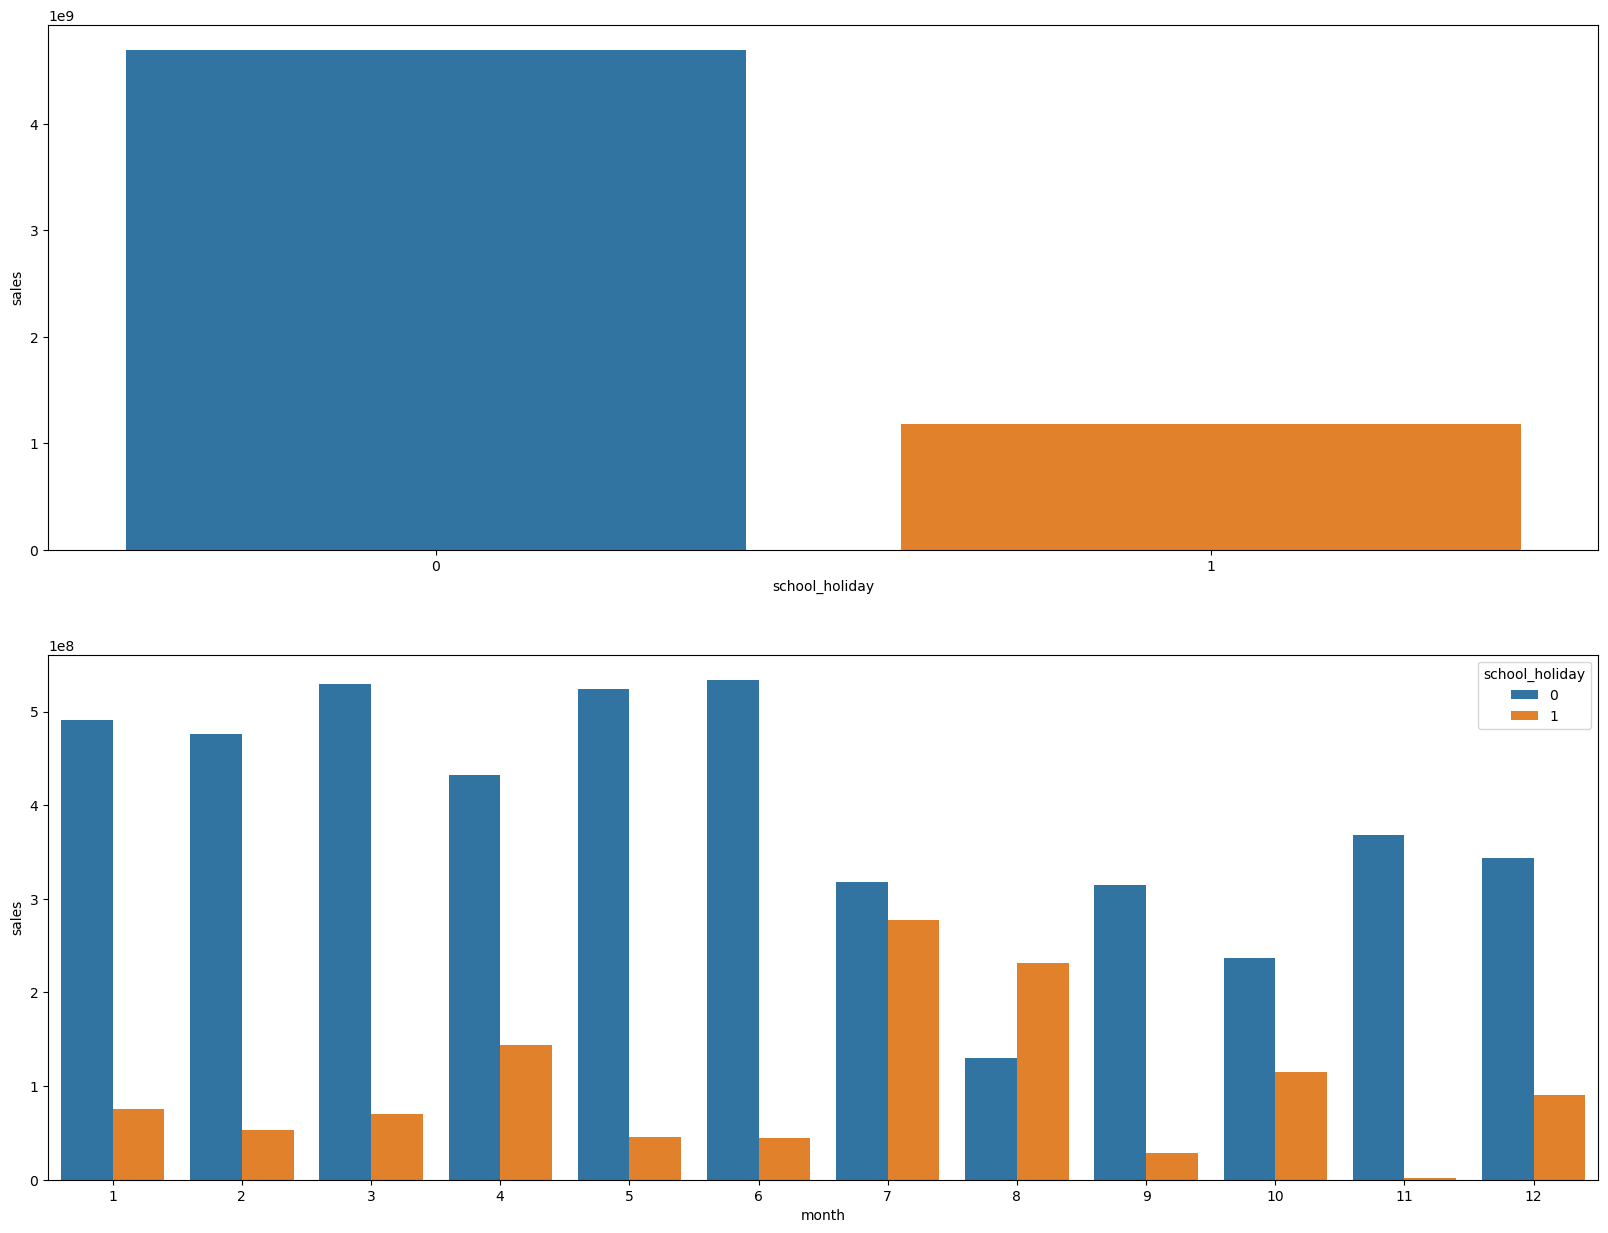

In [55]:
aux16 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux16);

plt.subplot(2,1,2)
aux17 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux17)


### Resumo das hipoteses

In [56]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Atributos numericos

<Axes: >

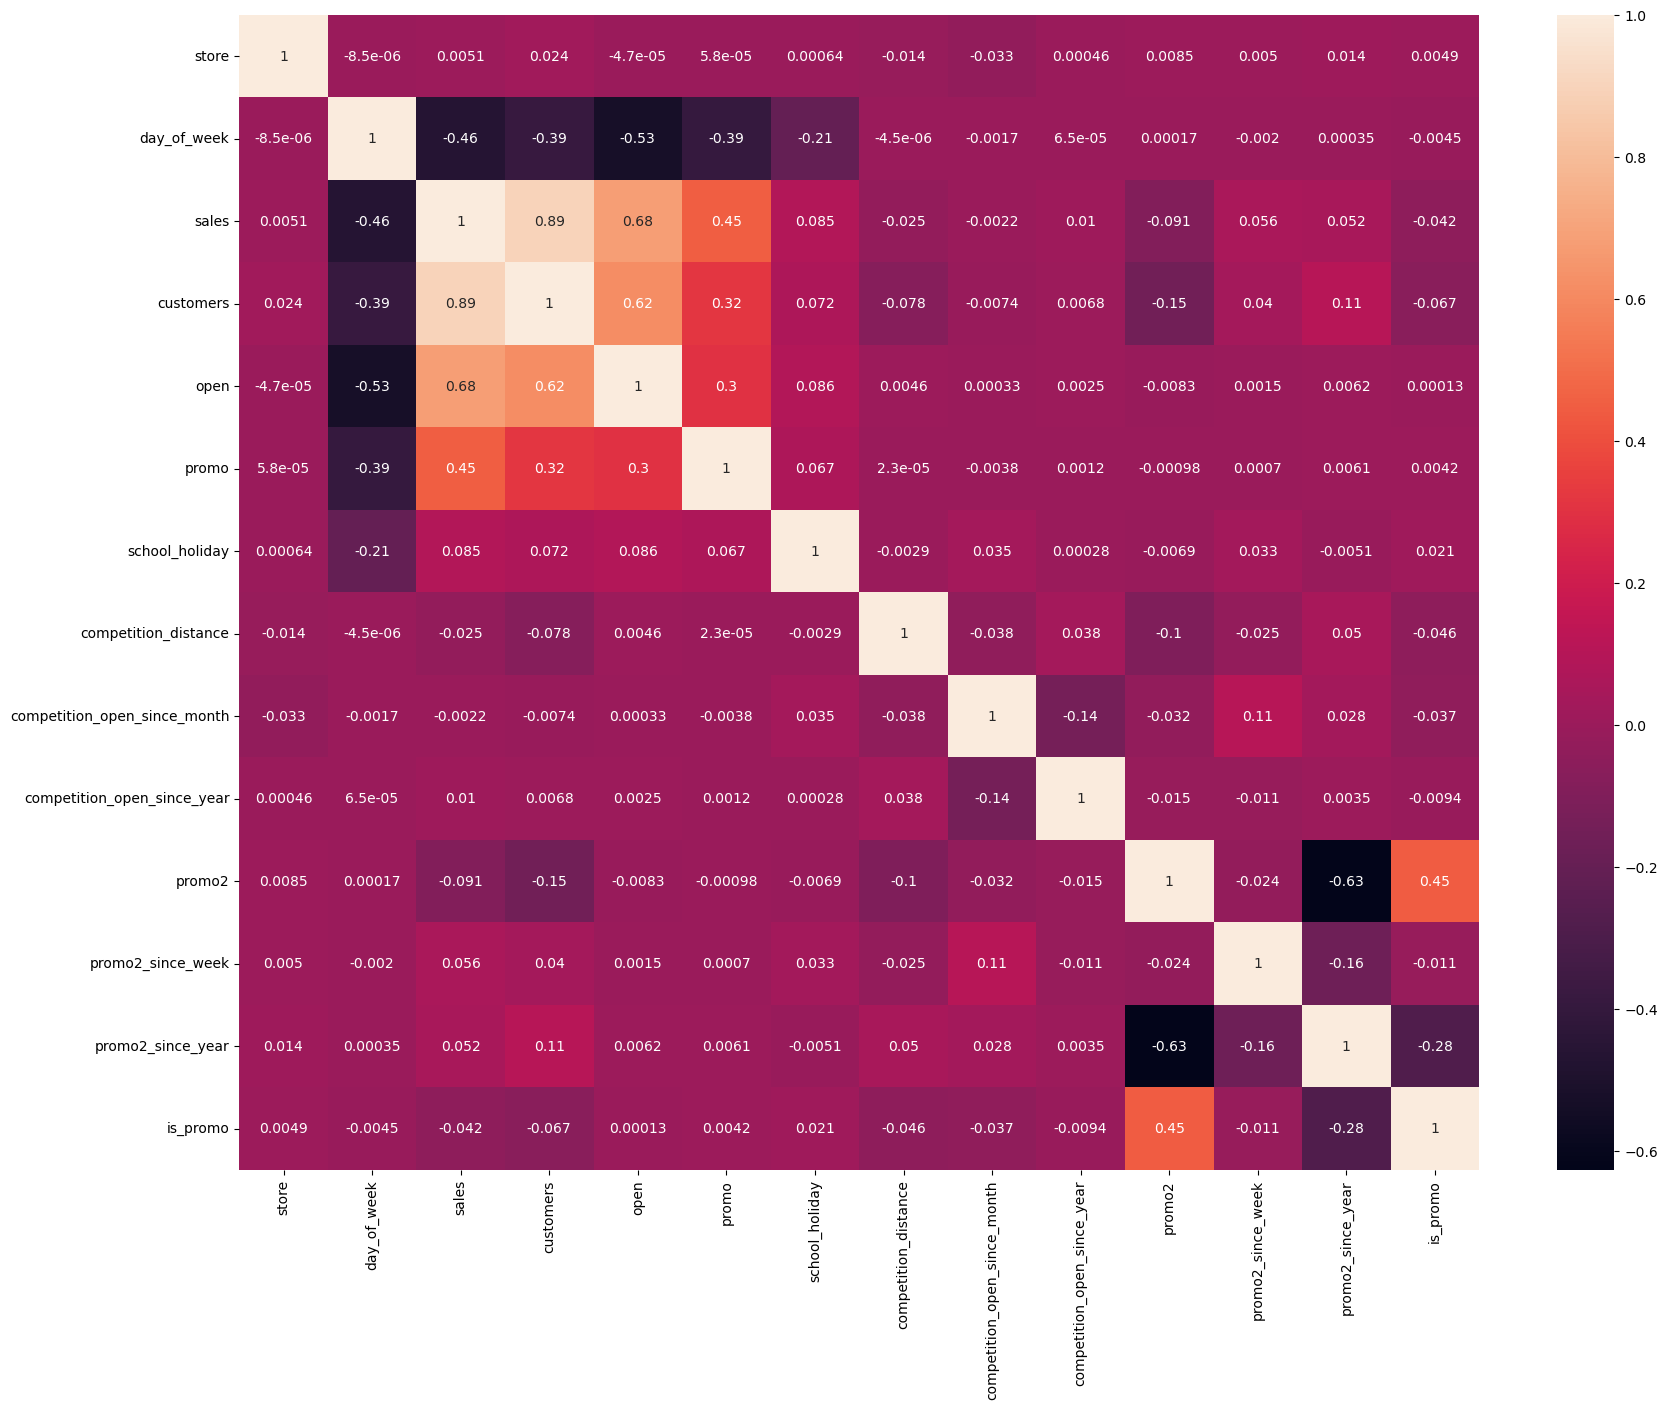

In [57]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Atributos categoricos

In [58]:
# apenas dados categoricos
a = df4.select_dtypes(include='object')


# calculo Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


# Dataset final
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

<Axes: >

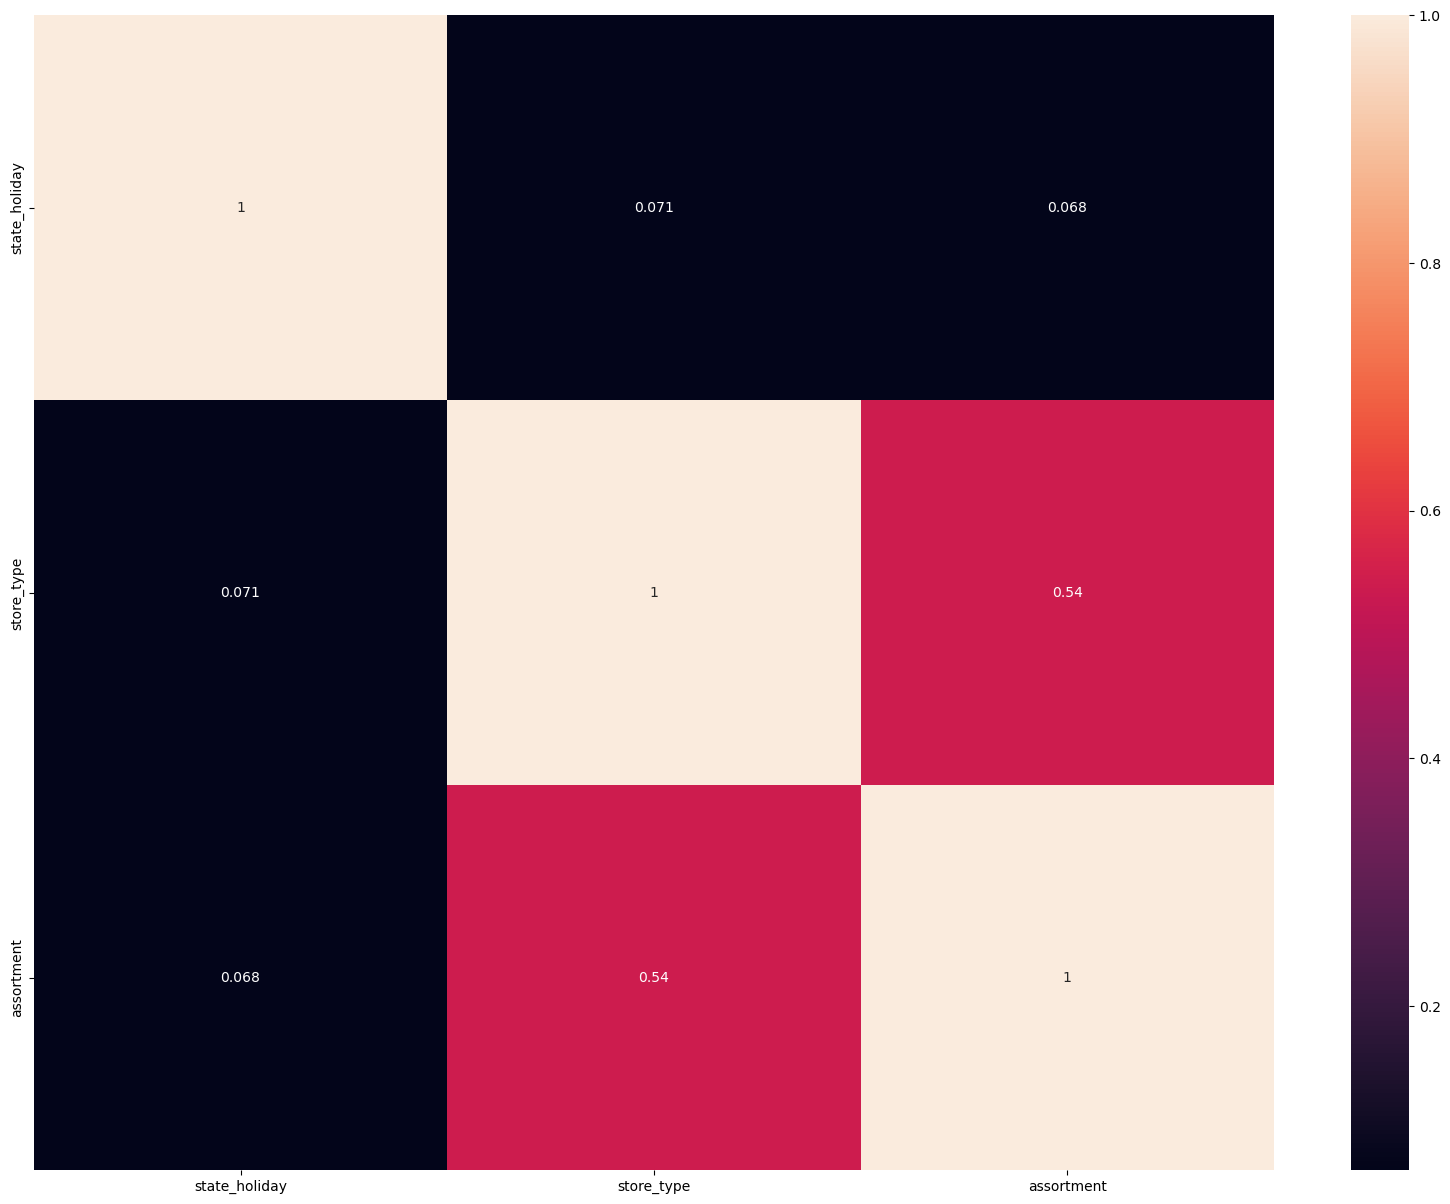

In [59]:
sns.heatmap(d, annot=True)

# 5.0 PASSO 05 - PREPARACAO DOS DADOS

In [60]:
df5 = df4.copy()

## 5.1 Normalizacao

Não efetuada pois as variáveis numéricas não apresentam proximidade de distribuição normal

## 5.2 Rescaling

In [61]:
a = df5.select_dtypes(include=['int64', 'int32', 'float64', 'float32'])

In [62]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [63]:
#state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [64]:
#store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [65]:
#assortment - Ordinal Enconding
assortment_dict = {'a': 1, 'b': 2, 'c': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação da variável resposta

In [66]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Transformação de natureza

In [67]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# 6.0 PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [68]:
df6 = df5.copy()

## 6.1 Divisão do dataframe inicial entre treino e teste

In [69]:
cols_drop = ['week_of_year', 'month', 'day', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [70]:
# definindo a data corte entre treino e teste para separação dos dados para treino e teste do modelo
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [71]:
# dataset treino
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# dataset teste
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}'. format(x_train['date'].min()))
print('Training Max Date: {}'. format(x_train['date'].max()))

print('\nTest Min Date: {}'. format(x_test['date'].min()))
print('Test Max Date: {}'. format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Seleção de variáveis com Boruta

In [72]:
# dataset de treino e teste para o Boruta
x_train_n = x_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

# definição do RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

In [73]:
#definição do Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1 Melhores variáveis - Boruta

In [74]:
#cols_selected = boruta.support_.tolist()

# melhores variaveis
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#col_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# variaveis não selecionadas
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, col_selected_boruta))

In [75]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 PASSO 07 - MODELOS DE MACHINE LEARNING

In [76]:
x1_train = x_train[cols_selected_boruta]
x1_test = x_test[cols_selected_boruta]

# Time series data preparation
x_training = x_train[cols_selected_boruta_full]

## 7.1 Modelo de média (Average Model)

In [77]:
aux1 = x1_test.copy()
aux1['sales'] = y_test.copy()

# predições
aux2 = aux1[['store', 'sales']].groupby('store'). mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Regressão linear

In [78]:
# model
lr = LinearRegression().fit(x1_train, y_train)

# prediçção
yhat_lr = lr.predict(x1_test)

# performace
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Regressão Linear - CrossValidation

In [87]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

## 7.3 Regressão linear regularizada - Lasso

In [79]:
# model
lrr = Lasso(alpha=0.01).fit(x1_train, y_train)

# prediçção
yhat_lrr = lrr.predict(x1_test)

# performace
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - CrossValidantion

In [88]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)

## 7.4 Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x1_train, y_train)

# prediçção
yhat_rf = rf.predict(x1_test)

# performace
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest - CrossValidation

In [90]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [82]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, eta=0.01, 
                             max_depth=10,
                             subsample=0.7, 
                              colsample_bytree=0.9).fit(x1_train, y_train)

# prediçção,
yhat_xgb = model_xgb.predict(x1_test)

# performace
xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,6683.544086,0.949457,7330.812159


### 7.5.1 XGBoost - CrossValidation

In [91]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


## 7.6 Comparação das performances dos modelos

### 7.6.1 Single Performance

In [83]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost,6683.544086,0.949457,7330.812159


### 7.6.2 Real Performance

In [95]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51
